


# Анализ лояльности пользователей Яндекс Афиши

<b/>Введение:</b>
<br/>В ходе анализа лояльности пользователей Яндекс Афишы необходимо определить какие пользователи с большей вероятностью возвращаются на платформу и делают заказы повторно. Для этого необходимо осуществить действия, условно разделенные на следующие этапы:
<br/>1. Загрузка данных и знакомство с ними.
<br/>2. Предобработка загруженных данных.
<br/>3. Создание профиля пользователя.
<br/>4. Исследовательский анализ данных:
<br/>- исследование признаков первого заказа и их связи с возвращением на платформу;
<br/>- исследование поведения пользователей через показатели выручки и состава заказа;
<br/>- исследование временных характеристик первого заказа и их влияние на повторные покупки;
<br/>- корреляционный анализ количества покупок и признаков пользователя.
<br/>5. Общие выводы и рекомендации.

# Этапы выполнения проекта

# 1. Загрузка данных и их предобработка

---

**Задача 1.1:** Напишите SQL-запрос, выгружающий в датафрейм pandas необходимые данные. Используйте следующие параметры для подключения к базе данных `data-analyst-afisha`:

- **Хост** — `rc1b-wcoijxj3yxfsf3fs.mdb.yandexcloud.net`
- **База данных** — `data-analyst-afisha`
- **Порт** — `6432`
- **Аутентификация** — `Database Native`
- **Пользователь** — `praktikum_student`
- **Пароль** — `Sdf4$2;d-d30pp`

Для выгрузки используйте запрос из предыдущего урока и библиотеку SQLAlchemy.

Выгрузка из базы данных SQL должна позволить собрать следующие данные:

- `user_id` — уникальный идентификатор пользователя, совершившего заказ;
- `device_type_canonical` — тип устройства, с которого был оформлен заказ (`mobile` — мобильные устройства, `desktop` — стационарные);
- `order_id` — уникальный идентификатор заказа;
- `order_dt` — дата создания заказа (используйте данные `created_dt_msk`);
- `order_ts` — дата и время создания заказа (используйте данные `created_ts_msk`);
- `currency_code` — валюта оплаты;
- `revenue` — выручка от заказа;
- `tickets_count` — количество купленных билетов;
- `days_since_prev` — количество дней от предыдущей покупки пользователя, для пользователей с одной покупкой — значение пропущено;
- `event_id` — уникальный идентификатор мероприятия;
- `service_name` — название билетного оператора;
- `event_type_main` — основной тип мероприятия (театральная постановка, концерт и так далее);
- `region_name` — название региона, в котором прошло мероприятие;
- `city_name` — название города, в котором прошло мероприятие.

---


In [103]:
!pip install phik

In [104]:
import pandas as pd
from sqlalchemy import create_engine
# загружаем библиотеки для визуализации данных
import matplotlib.pyplot as plt
import seaborn as sns

In [105]:
import warnings
warnings.filterwarnings("ignore")

In [106]:
from phik import phik_matrix

In [107]:
db_config = {'user': 'praktikum_student', # имя пользователя
             'pwd': 'Sdf4$2;d-d30pp', # пароль
             'host': 'rc1b-wcoijxj3yxfsf3fs.mdb.yandexcloud.net',
             'port': 6432, # порт подключения
             'db': 'data-analyst-afisha' # название базы данных
             }

In [108]:
connection_string = 'postgresql://{}:{}@{}:{}/{}'.format(
    db_config['user'],
    db_config['pwd'],
    db_config['host'],
    db_config['port'],
    db_config['db'],
)

In [109]:
engine = create_engine(connection_string)

In [110]:
query = '''
SELECT user_id,
device_type_canonical,
order_id,
created_dt_msk AS order_dt,
created_ts_msk AS order_ts,
currency_code,
revenue,
tickets_count,
created_dt_msk::date - LAG(created_dt_msk::date ) OVER(PARTITION BY user_id ORDER BY created_dt_msk) AS days_since_prev,
p.event_id,
service_name,
e.event_name_code AS event_name,
e.event_type_main,
r.region_name,
c.city_name
FROM afisha.purchases AS p
INNER JOIN afisha.events AS e USING (event_id)
LEFT JOIN afisha.city AS c USING(city_id)
LEFT JOIN afisha.regions AS r USING(region_id)
WHERE device_type_canonical IN ('mobile','desktop') AND e.event_type_main != 'фильм'
ORDER BY user_id;
'''

Справочно: принципиально, чтобы тройные кавычки были отдельно на одной строке, иначе появляется синтаксическая ошибка

In [111]:
df = pd.read_sql_query(query, con = engine)

---

**Задача 1.2:** Изучите общую информацию о выгруженных данных. Оцените корректность выгрузки и объём полученных данных.

Предположите, какие шаги необходимо сделать на стадии предобработки данных — например, скорректировать типы данных.

Зафиксируйте основную информацию о данных в кратком промежуточном выводе.

---

In [112]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 290611 entries, 0 to 290610
Data columns (total 15 columns):
 #   Column                 Non-Null Count   Dtype         
---  ------                 --------------   -----         
 0   user_id                290611 non-null  object        
 1   device_type_canonical  290611 non-null  object        
 2   order_id               290611 non-null  int64         
 3   order_dt               290611 non-null  datetime64[ns]
 4   order_ts               290611 non-null  datetime64[ns]
 5   currency_code          290611 non-null  object        
 6   revenue                290611 non-null  float64       
 7   tickets_count          290611 non-null  int64         
 8   days_since_prev        268678 non-null  float64       
 9   event_id               290611 non-null  int64         
 10  service_name           290611 non-null  object        
 11  event_name             290611 non-null  object        
 12  event_type_main        290611 non-null  obje

In [113]:
df.head(3)

,user_id,device_type_canonical,order_id,order_dt,order_ts,currency_code,revenue,tickets_count,days_since_prev,event_id,service_name,event_name,event_type_main,region_name,city_name
0,0002849b70a3ce2,mobile,4359165,2024-08-20,2024-08-20 16:08:03,rub,1521.94,4,NaN,169230,Край билетов,f0f7b271-04eb-4af6-bcb8-8f05cf46d6ad,театр,Каменевский регион,Глиногорск
1,0005ca5e93f2cf4,mobile,7965605,2024-07-23,2024-07-23 18:36:24,rub,289.45,2,NaN,237325,Мой билет,40efeb04-81b7-4135-b41f-708ff00cc64c,выставки,Каменевский регион,Глиногорск
2,0005ca5e93f2cf4,mobile,7292370,2024-10-06,2024-10-06 13:56:02,rub,1258.57,4,75.0,578454,За билетом!,01f3fb7b-ed07-4f94-b1d3-9a2e1ee5a8ca,другое,Каменевский регион,Глиногорск


<b/>Промежуточный вывод:</b>
<br/> В рассматриваемом датасете содержится 15 столбцов и 290611 строк. Названия столбцов приведены к стилю snake_case и отображают имеющиес в них данные. Восемь столбцов являются категориальными и имеют тип данных object. Пять столбцов являются числовыми и ещё два имеют тип данных datetime64. Изменять тип данных в столбце days_since_prev с float64 на int нецелесообразно, поскольку в столбце должны оставаться пропуски данных. Возможно понизить размерность некоторым числовым столбцам. Пропуски данных имеются только в столбце days_since_prev, но не составляют значимое количество. Сами данные соответствуют описанию и выглядят корректными.

In [114]:
# Создаем копию датасета до преобразования для возможности проверки сделанных изменений.
temp = df.copy()
len(temp)

290611

---
# 2. Предобработка данных

Выполните все стандартные действия по предобработке данных:

---

**Задача 2.1:** Данные о выручке сервиса представлены в российских рублях и казахстанских тенге. Приведите выручку к единой валюте — российскому рублю.

Для этого используйте датасет с информацией о курсе казахстанского тенге по отношению к российскому рублю за 2024 год — `final_tickets_tenge_df.csv`. Его можно загрузить по пути `https://code.s3.yandex.net/datasets/final_tickets_tenge_df.csv')`

Значения в рублях представлено для 100 тенге.

Результаты преобразования сохраните в новый столбец `revenue_rub`.

---


In [115]:
df_exchange = pd.read_csv('https://code.s3.yandex.net/datasets/final_tickets_tenge_df.csv')

In [116]:
df_exchange.head(3)

,data,nominal,curs,cdx
0,2024-01-10,100,19.9391,kzt
1,2024-01-11,100,19.7255,kzt
2,2024-01-12,100,19.5839,kzt


In [117]:
df_exchange.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 357 entries, 0 to 356
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   data     357 non-null    object 
 1   nominal  357 non-null    int64  
 2   curs     357 non-null    float64
 3   cdx      357 non-null    object 
dtypes: float64(1), int64(1), object(2)
memory usage: 11.3+ KB


В связи с тем, что необходимое поле для сравнения order_dt рассматриваемого датасета имеет тип данных datetime64, то для корректного сравнения необходимо произвести изменение типа данных столбца data

In [118]:
df_exchange['data'] = pd.to_datetime(df_exchange['data'])

In [119]:
df_exchange.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 357 entries, 0 to 356
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   data     357 non-null    datetime64[ns]
 1   nominal  357 non-null    int64         
 2   curs     357 non-null    float64       
 3   cdx      357 non-null    object        
dtypes: datetime64[ns](1), float64(1), int64(1), object(1)
memory usage: 11.3+ KB


In [120]:
# Функция для конвертации выручки
def convert_to_rub(row):
    if row['currency_code'] == 'rub':
        return row['revenue']  # уже в рублях
    else:
        # Находим курс на дату заказа
        rate_row = df_exchange[df_exchange['data'] == row['order_dt']]
        # доступ к элементам по целочисленному индексу (как в списках).[0] — берёт первый элемент серии (нулевой индекс)
        # Предполагает, что для каждой даты есть ровно одна запись в df_exchange
        rub_per_100_kzt = rate_row['curs'].iloc[0]
        # Переводим тенге в рубли: revenue_kzt * (руб/100 тенге) / 100
        return row['revenue'] * rub_per_100_kzt / 100
    
# Применяем конвертацию
df['revenue_rub'] = df.apply(convert_to_rub, axis=1)
# применять функцию к каждой строке (а не к каждому столбцу)

In [121]:
# Смотрим результат
print(df[['order_id', 'currency_code', 'revenue', 'revenue_rub']].head(100))

    order_id currency_code  revenue  revenue_rub
0    4359165           rub  1521.94  1521.940000
1    7965605           rub   289.45   289.450000
2    7292370           rub  1258.57  1258.570000
3    1139875           rub     8.49     8.490000
4     972400           rub  1390.41  1390.410000
..       ...           ...      ...          ...
95   4909643           rub    47.56    47.560000
96   7625522           kzt   328.77    61.148261
97   1413548           rub   103.20   103.200000
98   2680993           rub   824.54   824.540000
99   2681080           rub   412.27   412.270000

[100 rows x 4 columns]


Выручка в датасете была приведена к единой валюте - российскому рублю. Для этого был использован датасет с информацией о курсе казахстанского тенге по отношению к российскому рублю за 2024 год. Результаты преобразования были сохранены в новый столбец revenue_rub с типом данных datetime64.

---

**Задача 2.2:**

- Проверьте данные на пропущенные значения. Если выгрузка из SQL была успешной, то пропуски должны быть только в столбце `days_since_prev`.
- Преобразуйте типы данных в некоторых столбцах, если это необходимо. Обратите внимание на данные с датой и временем, а также на числовые данные, размерность которых можно сократить.
- Изучите значения в ключевых столбцах. Обработайте ошибки, если обнаружите их.
    - Проверьте, какие категории указаны в столбцах с номинальными данными. Есть ли среди категорий такие, что обозначают пропуски в данных или отсутствие информации? Проведите нормализацию данных, если это необходимо.
    - Проверьте распределение численных данных и наличие в них выбросов. Для этого используйте статистические показатели, гистограммы распределения значений или диаграммы размаха.
        
        Важные показатели в рамках поставленной задачи — это выручка с заказа (`revenue_rub`) и количество билетов в заказе (`tickets_count`), поэтому в первую очередь проверьте данные в этих столбцах.
        
        Если обнаружите выбросы в поле `revenue_rub`, то отфильтруйте значения по 99 перцентилю.

После предобработки проверьте, были ли отфильтрованы данные. Если были, то оцените, в каком объёме. Сформулируйте промежуточный вывод, зафиксировав основные действия и описания новых столбцов.

---

Проверка данных датасета на наличие пропущенных значений:

In [122]:
def show_missing_stats (tmp0):
    missing_stats = pd.DataFrame({
        'Кол-во пропусков': tmp0.isnull().sum(),
        'Доля пропусков': tmp0.isnull().mean()
    })
    missing_stats = missing_stats[missing_stats['Кол-во пропусков'] > 0]
    if missing_stats.empty:
        return "Пропусков в данных нет"
    return (missing_stats.style.format({'Доля пропусков': '{:.4f}'}).background_gradient(cmap='coolwarm'))
show_missing_stats(df)

,Кол-во пропусков,Доля пропусков
days_since_prev,21933,0.0755


Пропуски данных имеются только в столбце days_since_prev, что говорит об успешной выгрузке датасета из SQL. Исходя из полученных значений количество пропусков превышает 6 % и удаление строк, содержащих пропуски может повлиять на последующий исследовательский анализ данных.

Изменим тип данных столбца order_dt, так как в последующем будем работать только с датой

In [123]:
df['order_dt'] = df['order_dt'].dt.date

Понизим размерность столбцов с числовыми значениями.

In [124]:
for column in ['revenue', 'revenue_rub', 'days_since_prev']:
    df[column] = pd.to_numeric(df[column], downcast = 'float')

In [125]:
for colum in ['order_id', 'tickets_count', 'event_id']:
    df[colum] = pd.to_numeric(df[colum], downcast = 'integer')

In [126]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 290611 entries, 0 to 290610
Data columns (total 16 columns):
 #   Column                 Non-Null Count   Dtype         
---  ------                 --------------   -----         
 0   user_id                290611 non-null  object        
 1   device_type_canonical  290611 non-null  object        
 2   order_id               290611 non-null  int32         
 3   order_dt               290611 non-null  object        
 4   order_ts               290611 non-null  datetime64[ns]
 5   currency_code          290611 non-null  object        
 6   revenue                290611 non-null  float32       
 7   tickets_count          290611 non-null  int8          
 8   days_since_prev        268678 non-null  float32       
 9   event_id               290611 non-null  int32         
 10  service_name           290611 non-null  object        
 11  event_name             290611 non-null  object        
 12  event_type_main        290611 non-null  obje

Изменен тип данных столбца order_dt с datetime64 на object, понижена размерность столбцов с числовыми данными: revenue, revenue_rub, days_since_prev, order_id, tickets_count, event_id.

Справочно: номинальные данные (nominal data) — это категориальные данные, которые служат для обозначения (маркировки) объектов без количественной оценки или ранжирования.
В рассматриваемом датасете номинальные данные содержатся в следующих столбцах: device_type_canonical, currency_code, service_name, event_type_main, region_name, city_name.
Изучим их:

In [127]:
print(df['device_type_canonical'].unique())
df['device_type_canonical'].nunique()

['mobile' 'desktop']


2

In [128]:
print(df['currency_code'].unique())
df['currency_code'].nunique()

['rub' 'kzt']


2

In [129]:
print(df['service_name'].unique())
df['service_name'].nunique()

['Край билетов' 'Мой билет' 'За билетом!' 'Лови билет!'
 'Билеты без проблем' 'Облачко' 'Лучшие билеты' 'Прачечная' 'Быстробилет'
 'Дом культуры' 'Весь в билетах' 'Билеты в руки' 'Тебе билет!'
 'Show_ticket' 'Городской дом культуры' 'Яблоко' 'Билет по телефону'
 'Выступления.ру' 'Росбилет' 'Шоу начинается!' 'Мир касс' 'Восьмёрка'
 'Телебилет' 'Crazy ticket!' 'Реестр' 'Быстрый кассир' 'КарандашРУ'
 'Радио ticket' 'Дырокол' 'Вперёд!' 'Кино билет' 'Цвет и билет' 'Зе Бест!'
 'Тех билет' 'Лимоны' 'Билеты в интернете']


36

In [130]:
print(df['event_type_main'].unique())
df['event_type_main'].nunique()

['театр' 'выставки' 'другое' 'стендап' 'концерты' 'спорт' 'ёлки']


7

In [131]:
print(df['region_name'].unique())
df['region_name'].nunique()

['Каменевский регион' 'Североярская область' 'Озернинский край'
 'Лугоградская область' 'Поленовский край' 'Широковская область'
 'Медовская область' 'Златопольский округ' 'Малиновоярский округ'
 'Яблоневская область' 'Ветренский регион' 'Боровлянский край'
 'Крутоводская область' 'Ягодиновская область' 'Серебряноярский округ'
 'Лесодальний край' 'Верхоречная область' 'Горицветская область'
 'Речиновская область' 'Травиницкий округ' 'Сосновская область'
 'Серебринская область' 'Травяная область' 'Каменноярский край'
 'Солнечноземская область' 'Светополянский округ' 'Заречная область'
 'Ручейковский край' 'Глиногорская область' 'Тепляковская область'
 'Каменноозёрный край' 'Солнечнореченская область' 'Зоринский регион'
 'Берёзовская область' 'Лесостепной край' 'Малиновая область'
 'Синегорский регион' 'Луговая область' 'Шанырский регион'
 'Каменополянский округ' 'Речицкая область' 'Горностепной регион'
 'Речицкий регион' 'Золотоключевской край' 'Лесоярская область'
 'Зеленоградский окру

81

In [132]:
print(df['city_name'].unique())
df['city_name'].nunique()

['Глиногорск' 'Озёрск' 'Родниковецк' 'Кристалевск' 'Дальнозолотск'
 'Радужнополье' 'Радужсвет' 'Кумсай' 'Верховино' 'Светополье' 'Кокжар'
 'Каменский' 'Лесоярич' 'Никольянов' 'Речинцево' 'Лесозолотск'
 'Дальнозерск' 'Серебрянка' 'Островецк' 'Родниковец' 'Дальнесветск'
 'Луговаярово' 'Дальнополин' 'Ягодиновка' 'Солчелуг' 'Озёрчане'
 'Серебровино' 'Лесоярово' 'Глинополье' 'Глиноград' 'Дальнесветин'
 'Северополье' 'Теплоозеро' 'Горнодолинск' 'Ордакент' 'Озёрово'
 'Луговинск' 'Лугоград' 'Златопольск' 'Крутовинск' 'Сарыжар' 'Сосновечин'
 'Тихоярск' 'Яблонецк' 'Жаркентай' 'Широковка' 'Синеводов' 'Синеводск'
 'Тихосветск' 'Радужанов' 'Глиногорь' 'Каменосветск' 'Родниковск'
 'Травогород' 'Глинянск' 'Радужинск' 'Поляногорье' 'Дальнолесье'
 'Ручейник' 'Ключеград' 'Ключеводск' 'Поленовино' 'Речичанск'
 'Ключевополье' 'Шаныртау' 'Дальнесоснов' 'Ордасай' 'Теплоозёрск'
 'Чистогорье' 'Ручейный' 'Островярово' 'Ягодинск' 'Поленоозёрово'
 'Акбасты' 'Медовино' 'Каменёвка' 'Рощино' 'Солнечнёвка' 'Верхозол

352

Изучены данные в столбцах device_type_canonical, currency_code, service_name, event_type_main, region_name, city_name. Ошибок в данных обнаружено не было. В столце event_type_main значение "другое" может обозначать отсутствие информации.

Проверим распределение численных данных в столбцах tickets_count, revenue_rub и наличие в них выбросов.

In [133]:
print('Статистические показатели столбца tickets_count:')
print(df['tickets_count'].describe())
df['tickets_count'].value_counts()

Статистические показатели столбца tickets_count:
count    290611.000000
mean          2.754311
std           1.170620
min           1.000000
25%           2.000000
50%           3.000000
75%           4.000000
max          57.000000
Name: tickets_count, dtype: float64


3     92247
2     83807
4     54812
1     41798
5     13476
6      4283
7        62
9        38
8        21
10       19
11       13
13        7
17        6
19        5
12        4
14        4
15        2
27        2
30        2
37        1
47        1
57        1
Name: tickets_count, dtype: int64

Статистические показатели столбца tickets_count: количество билетов в заказе находится в промежутке от 1 до 57, среднее - 2,7543, медиана - 3, стандартное отклонение - 1,1706.
Разброс велик (от 1 до 57), значит, в данных высокая вариативность.
Отрицательная асимметрия (скос влево). Среднее < медианы (2,7543 < 3), следовательно в данных есть низкие значения, которые «тянут» среднее вниз.

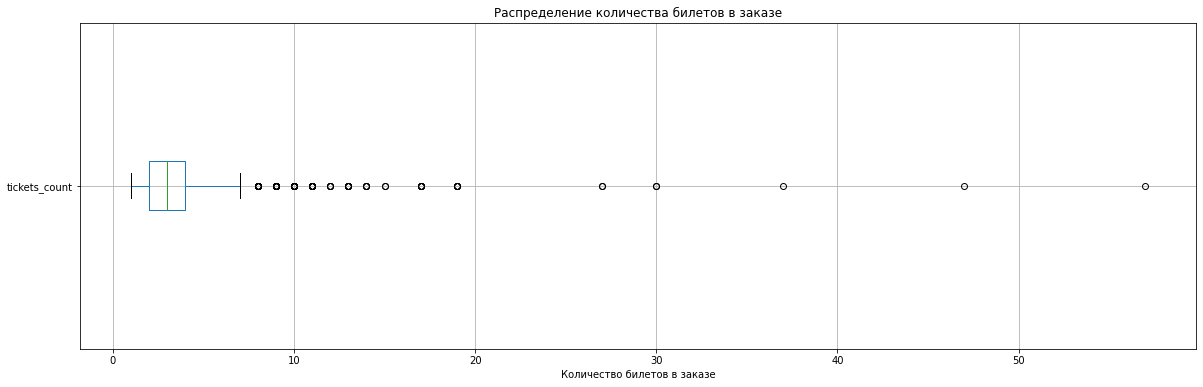

In [134]:
plt.figure(figsize=(20,6))
df.boxplot(column='tickets_count', vert=False)
plt.title('Распределение количества билетов в заказе')
plt.xlabel('Количество билетов в заказе')
plt.show()

In [135]:
Q1 = df['tickets_count'].quantile(0.25)
Q3 = df['tickets_count'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
outliers = df[(df['tickets_count'] < lower_bound) | (df['tickets_count'] > upper_bound)]
print("Выбросы по количеству билетов в заказе:")
print(outliers[['service_name', 'tickets_count']].sort_values('tickets_count', ascending=False))

Выбросы по количеству билетов в заказе:
              service_name  tickets_count
154001  Билеты без проблем             57
39413   Билеты без проблем             47
154585       Билеты в руки             37
154186  Билеты без проблем             30
154184  Билеты без проблем             30
...                    ...            ...
266685  Билеты без проблем              8
140783  Билеты без проблем              8
194122  Билеты без проблем              8
199308           Мой билет              8
267251        Край билетов              8

[126 rows x 2 columns]


Из 290611 заказов 126 имеют выбросы по количеству билетов в заказе, которые начинаются от значения 8 билетов в одном заказе.
<br/> «Типичное» значение следовательно лучше будет отражать медиана (3), а не среднее.

In [136]:
print('Статистические показатели столбца revenue_rub:')
print(df['revenue_rub'].describe())
df['revenue_rub'].value_counts()

Статистические показатели столбца revenue_rub:
count    290611.000000
mean        555.571960
std         875.498169
min         -90.760002
25%         113.970001
50%         351.140015
75%         802.049988
max       81174.539062
Name: revenue_rub, dtype: float64


0.000000       5526
1183.349976     795
788.900024      706
1577.800049     511
919.750000      450
               ... 
1221.089966       1
156.470001        1
1323.400024       1
284.329987        1
392.239990        1
Name: revenue_rub, Length: 43690, dtype: int64

Исходя из статистики в данных имеются ошибки, а именно отрицательные значения выручки. Посмотрим какое количество строк с такими ошибками:

In [137]:
df['revenue_rub'][df['revenue_rub'] < 0].count()

381

Игого имеется 381 ошибочных записей. Возможно сами значения верны, но их отрицательное значение неверно. Уберем знак "-".

In [138]:
df['revenue_rub'] = df['revenue_rub'].abs()

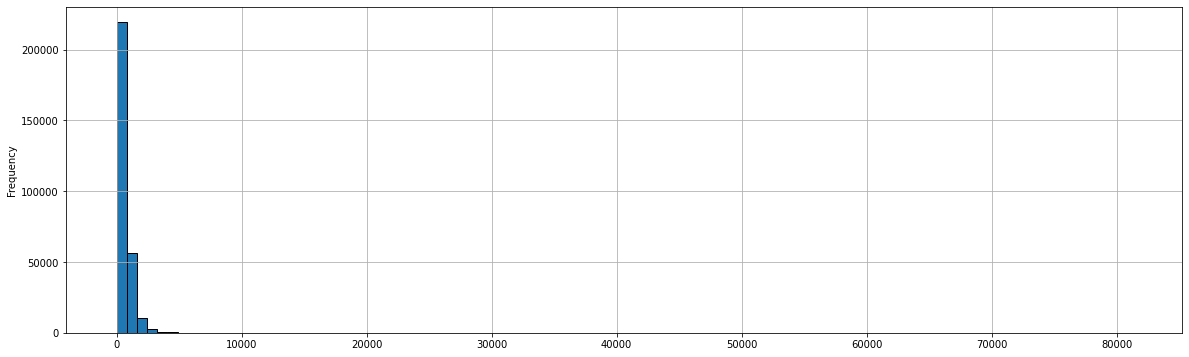

In [139]:
plt.figure(figsize=(20,6))
df['revenue_rub'].plot(
kind='hist',
    bins=100,
legend = False,
edgecolor='black')
plt.grid()
plt.show()

Как видно из графика имеются экстремальные выбросы, которые необходимо отсечь.

In [140]:
# Находим 99-й перцентиль
percentile_99 = df['revenue_rub'].quantile(0.99)
print("99-й перцентиль:", percentile_99)
# Фильтруем:
df_clean = df[df['revenue_rub'] <= percentile_99]
print("Исходное количество строк:", len(df))
print("После фильтрации:", len(df_clean))
print("Относительная доля отфильтрованных данных:", (len(df) - len(df_clean)) / len(df))

99-й перцентиль: 2628.421630859375
Исходное количество строк: 290611
После фильтрации: 287786
Относительная доля отфильтрованных данных: 0.009720898383061893


В ходе предобработки было отфильтровано около 1% от исходного количества данных.

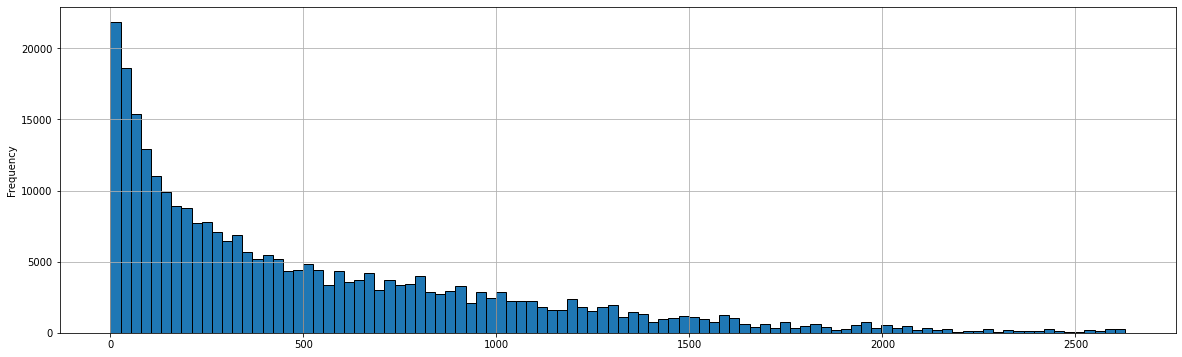

In [141]:
plt.figure(figsize=(20,6))
df_clean['revenue_rub'].plot(
kind='hist',
    bins=100,
legend = False,
edgecolor='black')
plt.grid()
plt.show()

In [142]:
df_clean['revenue_rub'].describe()

count    287786.000000
mean        518.035828
std         511.957092
min           0.000000
25%         111.849998
50%         343.849991
75%         788.659973
max        2628.421631
Name: revenue_rub, dtype: float64

Стандартное отклонение (511,96) почти равно среднему (518,04). Это говорит о высокой вариативности: значения сильно отклоняются от среднего.
<br/> Среднее > медианы, следовательно распределение скошено вправо (положительная асимметрия).
<br/> Большая часть значений сконцентрирована левее среднего, но есть длинный «хвост» из высоких значений (до 2 628).
<br/> Максимум = 2 628 примерно в 5 раз выше 75‑го перцентиля, что указывает на потенциальные выбросы в правом хвосте.
<br/> «Типичное» значение лучше отражает медиана (343,85), а не среднее.

In [143]:
Q_1 = df_clean['revenue_rub'].quantile(0.25)
Q_3 = df_clean['revenue_rub'].quantile(0.75)
IQR_1 = Q_3 - Q_1
lower_bound_1 = Q_1 - 1.5 * IQR_1
upper_bound_1 = Q_3 + 1.5 * IQR_1
outliers_1 = df_clean[(df_clean['revenue_rub'] < lower_bound_1) | (df_clean['revenue_rub'] > upper_bound_1)]
print("Выбросы по выручке с заказа:")
print(outliers_1[['service_name', 'revenue_rub']].sort_values('revenue_rub', ascending=False))

Выбросы по выручке с заказа:
              service_name  revenue_rub
74790            Мой билет  2628.421631
7268             Мой билет  2628.421631
243236           Мой билет  2628.421631
243237           Мой билет  2628.421631
83107            Мой билет  2628.421631
...                    ...          ...
214654             Облачко  1804.410034
134459       Билеты в руки  1804.359985
124040       Билеты в руки  1804.359985
260371      Весь в билетах  1804.280029
261750  Билеты без проблем  1804.280029

[8368 rows x 2 columns]


In [144]:
len(outliers_1)/len(df_clean)

0.029077161501949365

Таким образом, в столбце имеется 8368 выбросов (со значениями выручки равными 1804,28 и больше), что составляет 2.9% данных.

<b/>Промежуточный вывод:</b>
<br/>Поскольку необходимо привести выручку к единой валюте - российскому рублю, был использован датасет с информацией о курсе казахстанского тенге по отношению к российскому рублю за 2024 год.
<br/> После его загрузки (df_exchange) тип данных поля data был изменен с object на datetime64 для его сравнения со значениями поля order_dt изучаемого датасета (df).
<br/> Далее значения в тенге были переведены в рубли, а результаты преобразования сохранены в новый столбец revenue_rub датасета df с типом данных float64.
<br/> Затем была проведена проверка датасета df на наличие пропущенных значений. Они были обнаружены только в столбце days_since_prev (7,6% от общего количества). Удаление строк, содержащих пропуски может повлиять на последующий исследовательский анализ данных.
<br/> После анализа типов используемых данных был изменен тип столбца order_dt и понижена размерность столбцов с числовыми значениями (revenue, revenue_rub, days_since_prev, order_id, tickets_count, event_id).
<br/> Далее была осуществлена проверка категорий, указанных в столбцах с номинальными данными. Ошибок в данных обнаружено не было. В столбцах event_type_main значение "другое" может обозначать отсутствие информации.
<br/> Проверка распределения числовых данных в столбцах tickets_count, revenue_rub и наличие в них выбросов показала, что:
<br/> в соответствии со статистическими показателями значения столбца tickets_count показывают высокую вариативность и отрицательнкую ассиметрию (скос влево). В столбце имеется 126 выбросов (значения равные 8 и более билетов в одном заказе). "Типичное" значение столбца отражаает медиана (3);
<br/> в ходе анализа столбца revenue_rub были обнаружены ошибки в данных (381 значение), которые заключались в отрицательном значении выручки. Отрицательные значения были преобразованы в положительные;
<br/> при дальнейшем анализе столбца были обнаружены экстремальные выбросы, которые необходимо было отсечь. Для этого значения столбца revenue_rub были отфильтрованы по 99 процентилю. Относительная доля отфильтрованных данных составила 0,00972;
<br/> в соответствии со статистическими показателями значения столбца revenue_rub показывают высокую вариативность и положительную ассиметрию (скос вправо). В столбце имеется 8368 выбросов (со значением выручки равными 1804,28 и больше), что составляет 2,9% отфильтрованных данных.

---

# 3. Создание профиля пользователя

В будущем отдел маркетинга планирует создать модель для прогнозирования возврата пользователей. Поэтому сейчас они просят вас построить агрегированные признаки, описывающие поведение и профиль каждого пользователя.

---

**Задача 3.1.** Постройте профиль пользователя — для каждого пользователя найдите:

- дату первого и последнего заказа;
- устройство, с которого был сделан первый заказ;
- регион, в котором был сделан первый заказ;
- билетного партнёра, к которому обращались при первом заказе;
- жанр первого посещённого мероприятия (используйте поле `event_type_main`);
- общее количество заказов;
- средняя выручка с одного заказа в рублях;
- среднее количество билетов в заказе;
- среднее время между заказами.

После этого добавьте два бинарных признака:

- `is_two` — совершил ли пользователь 2 и более заказа;
- `is_five` — совершил ли пользователь 5 и более заказов.

**Рекомендация:** перед тем как строить профиль, отсортируйте данные по времени совершения заказа.

---


In [145]:
df_user = df_clean.copy()

In [146]:
# Сортируем заказы по пользователю и дате (важно для "первого" заказа)
df_user = df_user.sort_values(['user_id', 'order_ts']).reset_index(drop=True)

In [147]:
# Группируем по user_id и агрегируем
user_profile = (df_user.groupby('user_id').agg(
        first_order_date=('order_ts', 'min'),           # дата первого заказа
        last_order_date=('order_ts', 'max'),          # дата последнего заказа
        total_orders=('order_ts', 'count'),           # общее кол-во заказов
        total_revenue=('revenue_rub', 'sum'),          # суммарная выручка
        total_tickets=('tickets_count', 'sum'),         # суммарное кол-во билетов
        # Для первого заказа берём первую строку в отсортированной группе
        first_device=('device_type_canonical', 'first'),
        first_region=('region_name', 'first'),
        first_partner=('service_name', 'first'),
        first_event_type=('event_type_main', 'first')).reset_index()
)

In [148]:
user_profile['total_tickets'] = user_profile['total_tickets'].astype(int)

In [149]:
# Вычисляем средние показатели
user_profile['avg_revenue_per_order'] = (user_profile['total_revenue'] / user_profile['total_orders']).round(2)
user_profile['avg_tickets_per_order'] = (user_profile['total_tickets'] / user_profile['total_orders']).round(2)

In [150]:
# Среднее время между заказами
def mean_time_between_orders(group):
    if len(group) < 2:
        return pd.NaT  # нет интервалов
    dates = group['order_ts'].sort_values() # отсортированный ряд дат заказов для пользователя
    diffs = dates.diff().dropna()  # вычисляет разницу между каждым последующим значением и предыдущим в ряду dates
    # dropna() удаляет все значения NaT из ряда для подсчета среднего времени между заказами
    return diffs.mean()  # среднее время между заказами

mean_intervals = (df_user.groupby('user_id').apply(mean_time_between_orders).rename('avg_time_between_orders'))

user_profile = user_profile.merge(mean_intervals, on='user_id', how='left')

Теперь добавим два бинарных признака

In [151]:
user_profile['is_two'] = (user_profile['total_orders'] >= 2).astype(int)
user_profile['is_five'] = (user_profile['total_orders'] >= 5).astype(int)

In [152]:
# Итоговый профиль пользователя
user_profile.head(3)

,user_id,first_order_date,last_order_date,total_orders,total_revenue,total_tickets,first_device,first_region,first_partner,first_event_type,avg_revenue_per_order,avg_tickets_per_order,avg_time_between_orders,is_two,is_five
0,0002849b70a3ce2,2024-08-20 16:08:03,2024-08-20 16:08:03,1,1521.939941,4,mobile,Каменевский регион,Край билетов,театр,1521.94,4.00,NaT,0,0
1,0005ca5e93f2cf4,2024-07-23 18:36:24,2024-10-06 13:56:02,2,1548.020020,6,mobile,Каменевский регион,Мой билет,выставки,774.01,3.00,74 days 19:19:38,1,0
2,000898990054619,2024-07-13 19:40:48,2024-10-23 15:12:00,3,2301.640137,8,mobile,Североярская область,Лови билет!,другое,767.21,2.67,50 days 21:45:36,1,0


По результатам решения данной подзадачи был построен профиль пользователя Яндекс Афишы (user_profile).

---

**Задача 3.2.** Прежде чем проводить исследовательский анализ данных и делать выводы, важно понять, с какими данными вы работаете: насколько они репрезентативны и нет ли в них аномалий.

Используя данные о профилях пользователей, рассчитайте:

- общее число пользователей в выборке;
- среднюю выручку с одного заказа;
- долю пользователей, совершивших 2 и более заказа;
- долю пользователей, совершивших 5 и более заказов.

Также изучите статистические показатели:

- по общему числу заказов;
- по среднему числу билетов в заказе;
- по среднему количеству дней между покупками.

По результатам оцените данные: достаточно ли их по объёму, есть ли аномальные значения в данных о количестве заказов и среднем количестве билетов?

Если вы найдёте аномальные значения, опишите их и примите обоснованное решение о том, как с ними поступить:

- Оставить и учитывать их при анализе?
- Отфильтровать данные по какому-то значению, например, по 95-му или 99-му перцентилю?

Если вы проведёте фильтрацию, то вычислите объём отфильтрованных данных и выведите статистические показатели по обновлённому датасету.

In [153]:
# Общее число пользователей в выборке
total_users = len(user_profile)

In [154]:
# Средняя выручка с одного заказа
total_revenue = (user_profile['avg_revenue_per_order'] * user_profile['total_orders']).sum()
total_orders = user_profile['total_orders'].sum()
avg_revenue_per_order = total_revenue / total_orders

In [155]:
# Доля пользователей с ≥ 2 заказов
two = user_profile['is_two'].mean()

In [156]:
# Доля пользователей с ≥ 5 заказов
five = user_profile['is_five'].mean()

In [157]:
# Статистические показатели по числовым столбцам
stats_total_orders = user_profile['total_orders'].describe()
stats_tickets = user_profile['avg_tickets_per_order'].describe()
user_profile['avg_days_between_orders'] = user_profile['avg_time_between_orders'].dt.days 
# для вычленения дней, иначе статистика малоперевариваемая
stats_days = user_profile['avg_days_between_orders'].describe()

In [158]:
print("1. Общее число пользователей:", total_users)
print("2. Средняя выручка с одного заказа (руб.):", round(avg_revenue_per_order, 2))
print("3. Доля пользователей с ≥ 2 заказов:", f"{round(two, 4)}")
print("4. Доля пользователей с ≥ 5 заказов:", f"{round(five, 4)}")
print("\n5. Статистика по общему числу заказов:")
print(stats_total_orders)
print("\n6. Статистика по среднему числу билетов в заказе:")
print(stats_tickets)
print("\n7. Статистика по среднему количеству дней между заказами:")
print(stats_days)

1. Общее число пользователей: 21854
2. Средняя выручка с одного заказа (руб.): 518.04
3. Доля пользователей с ≥ 2 заказов: 0.6171
4. Доля пользователей с ≥ 5 заказов: 0.2901

5. Статистика по общему числу заказов:
count    21854.000000
mean        13.168573
std        121.674800
min          1.000000
25%          1.000000
50%          2.000000
75%          5.000000
max      10181.000000
Name: total_orders, dtype: float64

6. Статистика по среднему числу билетов в заказе:
count    21854.000000
mean         2.743136
std          0.913090
min          1.000000
25%          2.000000
50%          2.750000
75%          3.080000
max         11.000000
Name: avg_tickets_per_order, dtype: float64

7. Статистика по среднему количеству дней между заказами:
count    13486.000000
mean        15.478719
std         22.199492
min          0.000000
25%          1.000000
50%          8.000000
75%         20.000000
max        148.000000
Name: avg_days_between_orders, dtype: float64


Оценка данных: общее количество - 21854 строк вполне достаточно по объему, необходимо учитывать, что порядка 40% из информации по среднему количеству дней между заказами является пустой. Аномальные значения в среднем количестве билете отсутствуют, так как максимальное значение 11 вполне похоже на правду. А вот в среднем количестве заказов явно имеются аномальные значения, на что показывает максимальное значение равное 10181. Найдем 95-й и 99-й процентиль данных в этом столбце.

In [159]:
percentile_99_orders = user_profile['total_orders'].quantile(0.99)
print("99-й перцентиль:", percentile_99_orders)
percentile_95_orders = user_profile['total_orders'].quantile(0.95)
print("95-й перцентиль:", percentile_99_orders)

99-й перцентиль: 152.0
95-й перцентиль: 152.0


In [160]:
a, b = len(user_profile[user_profile['total_orders']>152]), len(user_profile)
print(f'Общее количество строк: {b}, количество строк с аномальными значениями: {a}')

Общее количество строк: 21854, количество строк с аномальными значениями: 216


Учитывая сильное искажение, которые будут вносить аномальные данные в последующий анализ и равные значения 95-го и 99-го процентиля необходимо отфильтровать данные среднего количества заказов по 95-му процентилю.

In [161]:
user_profile_filtered = user_profile[user_profile['total_orders'] <= 152]
a, b = len(user_profile), len(user_profile_filtered)
print(" Было строк в исходном датасете", a,
     '\n', "Осталось строк в датасете после обработки", b,
     '\n', "Удалено строк в датасете после обработки", a-b,
     '\n', "Процент потерь", round((a-b)/a*100, 2))

 Было строк в исходном датасете 21854 
 Осталось строк в датасете после обработки 21638 
 Удалено строк в датасете после обработки 216 
 Процент потерь 0.99


<b/>Вывод статистических показателей по обновлённому датасету</b>

In [162]:
# Общее число пользователей в выборке
total_users_filtered = len(user_profile_filtered)
# Средняя выручка с одного заказа
total_revenue_filtered = (user_profile_filtered['avg_revenue_per_order'] * user_profile_filtered['total_orders']).sum()
total_orders_filtered = user_profile_filtered['total_orders'].sum()
avg_revenue_per_order_filtered = total_revenue_filtered / total_orders_filtered
# Доля пользователей с ≥ 2 заказов
two_filtered = user_profile_filtered['is_two'].mean()
# Доля пользователей с ≥ 5 заказов
five_filtered = user_profile_filtered['is_five'].mean()
# Статистические показатели по числовым столбцам
stats_total_orders_filtered = user_profile_filtered['total_orders'].describe()
stats_tickets_filtered = user_profile_filtered['avg_tickets_per_order'].describe()
user_profile_filtered['avg_days_between_orders'] = user_profile_filtered['avg_time_between_orders'].dt.days 
# для вычленения дней, иначе статистика малоперевариваемая
stats_days_filtered = user_profile_filtered['avg_days_between_orders'].describe()
print("1. Общее число пользователей:", total_users_filtered)
print("2. Средняя выручка с одного заказа (руб.):", round(avg_revenue_per_order_filtered, 2))
print("3. Доля пользователей с ≥ 2 заказов:", f"{round(two_filtered, 4)}")
print("4. Доля пользователей с ≥ 5 заказов:", f"{round(five_filtered, 4)}")
print("\n5. Статистика по общему числу заказов:")
print(stats_total_orders_filtered)
print("\n6. Статистика по среднему числу билетов в заказе:")
print(stats_tickets_filtered)
print("\n7. Статистика по среднему количеству дней между заказами:")
print(stats_days_filtered)

1. Общее число пользователей: 21638
2. Средняя выручка с одного заказа (руб.): 522.2
3. Доля пользователей с ≥ 2 заказов: 0.6133
4. Доля пользователей с ≥ 5 заказов: 0.283

5. Статистика по общему числу заказов:
count    21638.000000
mean         6.501294
std         14.324031
min          1.000000
25%          1.000000
50%          2.000000
75%          5.000000
max        152.000000
Name: total_orders, dtype: float64

6. Статистика по среднему числу билетов в заказе:
count    21638.000000
mean         2.743327
std          0.917496
min          1.000000
25%          2.000000
50%          2.750000
75%          3.100000
max         11.000000
Name: avg_tickets_per_order, dtype: float64

7. Статистика по среднему количеству дней между заказами:
count    13270.000000
mean        15.730671
std         22.290719
min          0.000000
25%          1.000000
50%          8.000000
75%         20.000000
max        148.000000
Name: avg_days_between_orders, dtype: float64


<b/>Выводы по статистике:</b>
<br/>База пользователей и выручка: в системе 21 638 пользователей, средний доход с одного заказа — 522,2 руб.
<br/>Лояльность аудитории: более 61 % пользователей совершают 2 и более заказа (высокая вовлечённость части аудитории); почти 28 % пользователей делают 5 и более заказов — это ядро лояльных клиентов.
<br/>Частота заказов: в среднем пользователь делает 6,5 заказов (при сильном разбросе: от 1 до 152); медиана (50 %) — 2 заказа, а 75 % пользователей имеют 5 и менее заказов: распределение скошено вправо — большинство делает мало заказов, но есть активные пользователи с большим числом покупок.
<br/>Объём покупок за заказ: в среднем в заказе 2,74 билета; разброс небольшой (от 1 до 11), большинство значений сконцентрировано вокруг медианы (~2,75–3,1 билета).
<br/>Периодичность заказов: данные есть только для 13 270 пользователей (≈61 % от общего числа); в среднем между заказами проходит 15,7 дней, но разброс велик (стандартное отклонение — 22,3 дня); половина пользователей делает повторные заказы в течение 8 дней, 75 % — в течение 20 дней; максимум — 148 дней между заказами: есть как частые, так и редкие покупатели.
<br/>Краткие итоги:
<br/>- аудитория неоднородна: есть малоактивные пользователи (1 заказ) и высокоактивные (до 152 заказов);
<br/>- ядро лояльности — 28 % клиентов с 5+ заказами — ключевой источник выручки;
<br/>- типичная покупка: 2–3 билета, в среднем каждые 15–20 дней;
<br/>- потенциал роста: вовлечение пользователей с 1–2 заказами в повторные покупки может заметно увеличить общую выручку.

---

# 4. Исследовательский анализ данных

Следующий этап — исследование признаков, влияющих на возврат пользователей, то есть на совершение повторного заказа. Для этого используйте профили пользователей.



# 4.1. Исследование признаков первого заказа и их связи с возвращением на платформу

Исследуйте признаки, описывающие первый заказ пользователя, и выясните, влияют ли они на вероятность возвращения пользователя.

---

**Задача 4.1.1.** Изучите распределение пользователей по признакам.

- Сгруппируйте пользователей:
    - по типу их первого мероприятия;
    - по типу устройства, с которого совершена первая покупка;
    - по региону проведения мероприятия из первого заказа;
    - по билетному оператору, продавшему билеты на первый заказ.
- Подсчитайте общее количество пользователей в каждом сегменте и их долю в разрезе каждого признака. Сегмент — это группа пользователей, объединённых определённым признаком, то есть объединённые принадлежностью к категории. Например, все клиенты, сделавшие первый заказ с мобильного телефона, — это сегмент.
- Ответьте на вопрос: равномерно ли распределены пользователи по сегментам или есть выраженные «точки входа» — сегменты с наибольшим числом пользователей?

---


In [163]:
# Группировка по типу первого мероприятия
group_event = user_profile_filtered['first_event_type'].value_counts().reset_index()
# .reset_index() превращает серию из предыдущего шага в DataFrame
group_event.columns = ['segment', 'count']
group_event['feature'] = 'first_event_type'
# новая колонку feature со значением 'first_event_type' для всех строк
# Позволяет позже объединить несколько подобных таблиц (по устройствам, регионам и т. д.) 
# и понимать, к какому признаку относится каждый сегмент.
group_event['share'] = group_event['count'] / total_users_filtered
print("1. По типу первого мероприятия:")
print(group_event[['segment', 'count', 'share']])

1. По типу первого мероприятия:
    segment  count     share
0  концерты   9560  0.441815
1    другое   5426  0.250763
2     театр   4239  0.195905
3   стендап   1110  0.051299
4     спорт    794  0.036695
5  выставки    414  0.019133
6      ёлки     95  0.004390


Выраженная "точка входа": первое мероприятие "концерты" (44%)

In [164]:
# Группировка по устройству первого заказа
group_device = user_profile_filtered['first_device'].value_counts().reset_index()
group_device.columns = ['segment', 'count']
group_device['feature'] = 'first_device'
group_device['share'] = group_device['count'] / total_users_filtered
print("\n2. По устройству первого заказа:")
print(group_device[['segment', 'count', 'share']])


2. По устройству первого заказа:
   segment  count     share
0   mobile  17924  0.828358
1  desktop   3714  0.171642


Ярко выраженная "точка входа": устройство первого заказа мобильный телефон (83%)

In [165]:
# Группировка по региону первого заказа
group_region = user_profile_filtered['first_region'].value_counts().reset_index()
group_region.columns = ['segment', 'count']
group_region['feature'] = 'first_region'
group_region['share'] = group_region['count'] / total_users_filtered
print("\n3. По региону первого заказа:")
print(group_region[['segment', 'count', 'share']])


3. По региону первого заказа:
                     segment  count     share
0         Каменевский регион   7085  0.327433
1       Североярская область   3767  0.174092
2        Широковская область   1224  0.056567
3           Озернинский край    675  0.031195
4       Малиновоярский округ    525  0.024263
..                       ...    ...       ...
76       Тихогорская область      2  0.000092
77         Светолесский край      2  0.000092
78        Яснопольский округ      1  0.000046
79  Сосноводолинская область      1  0.000046
80         Верхозёрский край      1  0.000046

[81 rows x 3 columns]


"точки входа" региона первого заказа: "Каменевский регион" (33%) и "Североярская область" (17%), что в сумме составляет половину 

In [166]:
# Группировка по билетному партнёру первого заказа
group_partner = user_profile_filtered['first_partner'].value_counts().reset_index()
group_partner.columns = ['segment', 'count']
group_partner['feature'] = 'first_partner'
group_partner['share'] = group_partner['count'] / total_users_filtered
print("\n4. По билетному партнёру первого заказа:")
print(group_partner[['segment', 'count', 'share']])


4. По билетному партнёру первого заказа:
                   segment  count     share
0       Билеты без проблем   5186  0.239671
1                Мой билет   2969  0.137212
2              Лови билет!   2809  0.129818
3            Билеты в руки   2559  0.118264
4                  Облачко   2177  0.100610
5           Весь в билетах   1285  0.059386
6            Лучшие билеты   1184  0.054719
7                Прачечная    583  0.026943
8             Край билетов    454  0.020982
9             Дом культуры    356  0.016453
10                  Яблоко    318  0.014696
11             Тебе билет!    308  0.014234
12  Городской дом культуры    215  0.009936
13                Мир касс    209  0.009659
14             За билетом!    201  0.009289
15             Быстробилет    162  0.007487
16             Show_ticket    157  0.007256
17          Выступления.ру     95  0.004390
18               Восьмёрка     85  0.003928
19          Быстрый кассир     61  0.002819
20           Crazy ticket!     45 

основная точка входа: "Билеты без проблем" (24%)

<b/>Общий итог</b> 
<br/>Во всех категориях распределение пользователей не является равномерным — есть выраженные «точки входа» с наибольшим числом пользователей:
<br/>- тип мероприятия: концерты;
<br/>- устройство: mobile;
<br/>- регион: Каменевский регион;
<br/>- партнёр: «Билеты без проблем».

---

**Задача 4.1.2.** Проанализируйте возвраты пользователей:

- Для каждого сегмента вычислите долю пользователей, совершивших два и более заказа.
- Визуализируйте результат подходящим графиком. Если сегментов слишком много, то поместите на график только 10 сегментов с наибольшим количеством пользователей. Такое возможно с сегментами по региону и по билетному оператору.
- Ответьте на вопросы:
    - Какие сегменты пользователей чаще возвращаются на Яндекс Афишу?
    - Наблюдаются ли успешные «точки входа» — такие сегменты, в которых пользователи чаще совершают повторный заказ, чем в среднем по выборке?

При интерпретации результатов учитывайте размер сегментов: если в сегменте мало пользователей (например, десятки), то доли могут быть нестабильными и недостоверными, то есть показывать широкую вариацию значений.

---


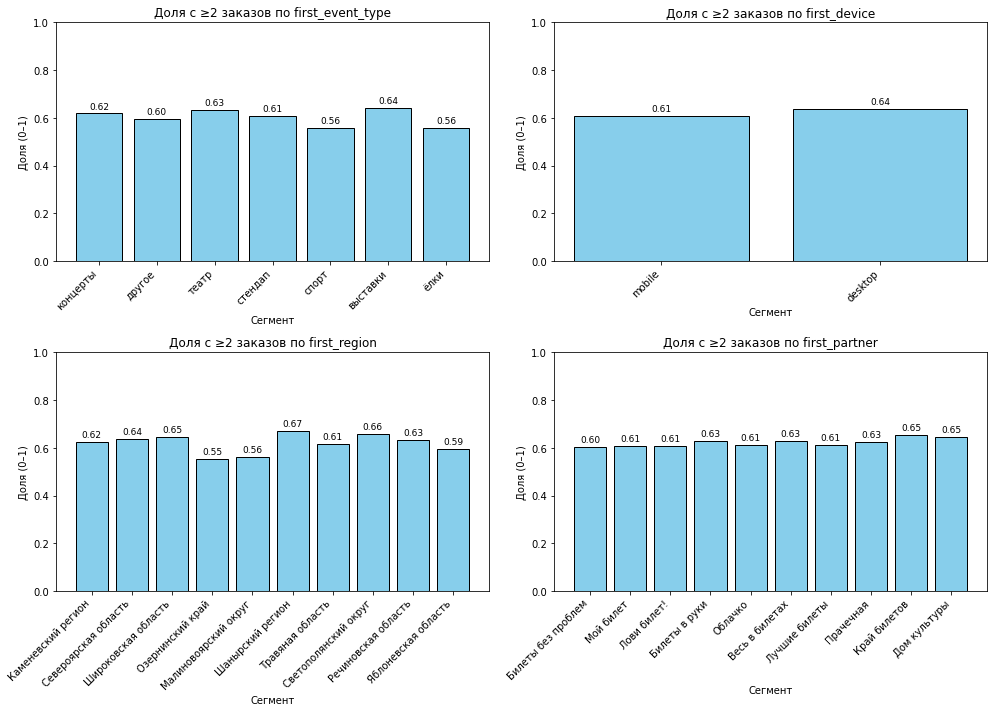

In [167]:
# Список признаков для сегментации
features = ['first_event_type', 'first_device', 'first_region', 'first_partner']

plt.figure(figsize=(14, 10))


for i, feature in enumerate(features, 1):
    # Группируем по признаку: считаем число пользователей и долю с ≥2 заказов
    agg_data = (
        user_profile_filtered
        .groupby(feature)
        .agg(
            count=('user_id', 'count'),
            two_plus=('is_two', 'sum')
        )
        .assign(share_two_plus=lambda x: x['two_plus'] / x['count'])
        .nlargest(10, 'count')  # Топ‑10 по числу пользователей
    )
    
    
    # Строим график для текущего признака
    plt.subplot(2, 2, i)
    plt.bar(agg_data.index, agg_data['share_two_plus'], color='skyblue', edgecolor='black')
    plt.title(f'Доля с ≥2 заказов по {feature}')
    plt.xlabel('Сегмент')
    plt.ylabel('Доля (0–1)')
    plt.xticks(rotation=45, ha='right')
    plt.ylim(0, 1)
    
    # Подписываем доли над столбцами
    for idx, val in enumerate(agg_data['share_two_plus']):
        plt.text(idx, val + 0.02, f'{val:.2f}', ha='center', fontsize=9)


plt.tight_layout()
plt.show()

In [168]:
for feature in features:
    agg_data = (
        user_profile_filtered
        .groupby(feature)
        .agg(
            count=('user_id', 'count'),
            two_plus=('is_two', 'sum')
        )
        .assign(share_two_plus=lambda x: x['two_plus'] / x['count'])
        .nlargest(10, 'count')
    )
    print(f"\n--- Доля с ≥2 заказов по {feature} ---")
    print(agg_data.to_string(float_format=lambda x: f"{x:.2f}"))


--- Доля с ≥2 заказов по first_event_type ---
                  count  two_plus  share_two_plus
first_event_type                                 
концерты           9560      5911            0.62
другое             5426      3235            0.60
театр              4239      2687            0.63
стендап            1110       676            0.61
спорт               794       443            0.56
выставки            414       265            0.64
ёлки                 95        53            0.56

--- Доля с ≥2 заказов по first_device ---
              count  two_plus  share_two_plus
first_device                                 
mobile        17924     10900            0.61
desktop        3714      2370            0.64

--- Доля с ≥2 заказов по first_region ---
                      count  two_plus  share_two_plus
first_region                                         
Каменевский регион     7085      4421            0.62
Североярская область   3767      2404            0.64
Широковская облас

Наиболее высокая доля пользователей с более чем двумя заказами наблюдается в следующих сегментах:
<br/>По региону первого заказа: Шанырский регион — 67 %; Широковская область — 65 %; Светополянский округ — 66 %.
<br/>По билетному партнёру: Край билетов — 65 %; Дом культуры — 65 %.
<br/>По типу первого мероприятия: выставки — 64 %.
<br/>По устройству: desktop — 64 %.

Наилучшие «точки входа» по региону — Шанырский регион (67 %), Широковская область (65 %) и Светоплянский округ (66 %).
<br/>По партнёрам выделяются «Край билетов» и «Дом культуры» (по 65 %), а также «Билеты в руки» и «Весь в билетах» (63 %).
<br/>Среди типов мероприятий выделяется сегмент «выставки» (64 %).
<br/>Пользователи, впервые зашедшие с desktop, возвращаются чаще (64 %), чем те, кто пришёл с mobile (61 %).

---

**Задача 4.1.3.** Опираясь на выводы из задач выше, проверьте продуктовые гипотезы:

- **Гипотеза 1.** Тип мероприятия влияет на вероятность возврата на Яндекс Афишу: пользователи, которые совершили первый заказ на спортивные мероприятия, совершают повторный заказ чаще, чем пользователи, оформившие свой первый заказ на концерты.
- **Гипотеза 2.** В регионах, где больше всего пользователей посещают мероприятия, выше доля повторных заказов, чем в менее активных регионах.

---

In [169]:
# Фильтруем данные
valid_types = ['спорт', 'концерты']
filtered_event = user_profile_filtered[user_profile_filtered['first_event_type'].isin(valid_types)]
# Группируем по типу мероприятия, считаем:
# общее число пользователей (total_users)
# число вернувшихся (stay)
grouped_event = (filtered_event.groupby('first_event_type').agg(total_users=('user_id', 'count'), stay=('is_two', 'sum')))
print("Статистика по сегментам:")
print(grouped_event)
# Извлекаем значения для сравнения
total_users_sport = grouped_event.loc['спорт', 'total_users']
stay_sport = grouped_event.loc['спорт', 'stay']
p_sport = stay_sport / total_users_sport  # доля вернувшихся у категории «спорт»


total_users_concert = grouped_event.loc['концерты', 'total_users']
stay_concert = grouped_event.loc['концерты', 'stay']
p_concert = stay_concert / total_users_concert  # доля вернувшихся у категории «концерты»


print(f"\nДоля вернувшихся (спорт): {p_sport:.3f}")
print(f"Доля вернувшихся (концерты): {p_concert:.3f}")


Статистика по сегментам:
                  total_users  stay
first_event_type                   
концерты                 9560  5911
спорт                     794   443

Доля вернувшихся (спорт): 0.558
Доля вернувшихся (концерты): 0.618


Гипотеза 1 подтверждается частично. Тип мероприятия влияет на вероятность возврата на Яндекс Афишу, но таким образом: пользователи, которые совершили первый заказ на концерты, совершают повторный заказ чаще, чем пользователи, оформившие свой первый заказ на спортивные мероприятия.

In [170]:
# Группируем по региону:
# - n_users: сколько пользователей в регионе;
# - two_plus: сколько из них сделали ≥2 заказов;
# - share: доля повторных заказов.
region_summary = (user_profile_filtered.groupby('first_region').agg(n_users=('user_id', 'count'),two_plus=('is_two', 'sum'))
    .assign(share=lambda x: x['two_plus'] / x['n_users'])
    .sort_values('n_users', ascending=False)  # сортируем по активности (убыв.)
)

# Выводим топ‑10 регионов в виде таблицы
print("Топ‑10 регионов по активности (число пользователей)")
print("=" * 60)
print(region_summary.head(10).to_string(
    float_format=lambda x: f"{x:.3f}" if x != int(x) else f"{int(x)}"
))

# 3. Простая интерпретация
top_share = region_summary['share'].head(10).mean()
bottom_share = region_summary['share'].tail(10).mean()

print("\n" + "=" * 60)
print("Анализ:")
print(f"- Средняя доля повторных заказов в топ‑10 активных регионах: {top_share:.1%}")
print(f"- Средняя доля повторных заказов в 10 наименее активных регионах: {bottom_share:.1%}")

Топ‑10 регионов по активности (число пользователей)
                      n_users  two_plus  share
first_region                                  
Каменевский регион       7085      4421  0.624
Североярская область     3767      2404  0.638
Широковская область      1224       790  0.645
Озернинский край          675       373  0.553
Малиновоярский округ      525       294  0.560
Шанырский регион          500       336  0.672
Травяная область          488       300  0.615
Светополянский округ      457       300  0.656
Речиновская область       440       279  0.634
Яблоневская область       411       244  0.594

Анализ:
- Средняя доля повторных заказов в топ‑10 активных регионах: 61.9%
- Средняя доля повторных заказов в 10 наименее активных регионах: 45.0%


Гипотеза 2 подтверждается. В регионах, где больше всего пользователей посещают мероприятия, выше доля повторных заказов, чем в менее активных регионах.

---

# 4.2. Исследование поведения пользователей через показатели выручки и состава заказа

Изучите количественные характеристики заказов пользователей, чтобы узнать среднюю выручку сервиса с заказа и количество билетов, которое пользователи обычно покупают.

Эти метрики важны не только для оценки выручки, но и для оценки вовлечённости пользователей. Возможно, пользователи с более крупными и дорогими заказами более заинтересованы в сервисе и поэтому чаще возвращаются.

---

**Задача 4.2.1.** Проследите связь между средней выручкой сервиса с заказа и повторными заказами.

- Постройте сравнительные гистограммы распределения средней выручки с билета (`avg_revenue_rub`):
    - для пользователей, совершивших один заказ;
    - для вернувшихся пользователей, совершивших 2 и более заказа.
- Ответьте на вопросы:
    - В каких диапазонах средней выручки концентрируются пользователи из каждой группы?
    - Есть ли различия между группами?

Текст на сером фоне:
    
**Рекомендация:**

1. Используйте одинаковые интервалы (`bins`) и прозрачность (`alpha`), чтобы визуально сопоставить распределения.
2. Задайте параметру `density` значение `True`, чтобы сравнивать форму распределений, даже если число пользователей в группах отличается.

---


In [171]:
# Разделяем пользователей на две группы
one_order = user_profile_filtered[user_profile_filtered['total_orders'] == 1]
two_plus_orders = user_profile_filtered[user_profile_filtered['total_orders'] >= 2]

In [172]:
# Статистика
print("Статистика по группам:")
print(f"Пользователи с 1 заказом: {len(one_order)} чел.")
print(f"Пользователи с ≥2 заказов: {len(two_plus_orders)} чел.")

print("\nСредняя выручка с билета (по группам):")
print(f"1 заказ: {one_order['avg_revenue_per_order'].mean():.2f} руб.")
print(f"≥2 заказов: {two_plus_orders['avg_revenue_per_order'].mean():.2f} руб.")

Статистика по группам:
Пользователи с 1 заказом: 8368 чел.
Пользователи с ≥2 заказов: 13270 чел.

Средняя выручка с билета (по группам):
1 заказ: 545.30 руб.
≥2 заказов: 544.34 руб.


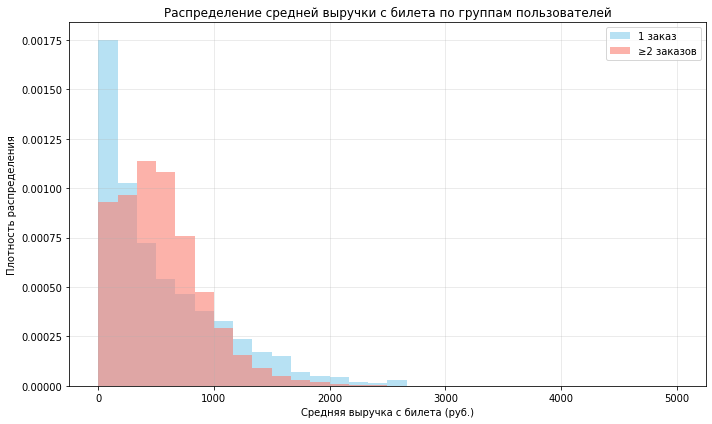

In [173]:
# Сравнительные гистограммы
plt.figure(figsize=(10, 6))
# Общие границы и бины для обеих гистограмм
bins = 30
range_lim = (0, 5000)  # ограничиваем диапазон

plt.hist(
    one_order['avg_revenue_per_order'],
    bins=bins,
    range=range_lim,
    alpha=0.6,
    label='1 заказ',
    color='skyblue',
    density=True  # нормируем на площадь = 1
)

plt.hist(
    two_plus_orders['avg_revenue_per_order'],
    bins=bins,
    range=range_lim,
    alpha=0.6,
    label='≥2 заказов',
    color='salmon',
    density=True
)

# Оформляем график
plt.xlabel('Средняя выручка с билета (руб.)')
plt.ylabel('Плотность распределения')
plt.title('Распределение средней выручки с билета по группам пользователей')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

Поскольку гистограмма «≥2 заказов» сдвинута вправо — вернувшиеся пользователи покупают более дорогие билеты.

In [174]:
# квантили для описания диапазонов
print("\nДиапазоны выручки (квантили):")
print("1 заказ (руб.):")
print(one_order['avg_revenue_per_order'].quantile([0.25, 0.5, 0.75]).round(2).to_string())
print("\n≥2 заказов (руб.):")
print(two_plus_orders['avg_revenue_per_order'].quantile([0.25, 0.5, 0.75]).round(2).to_string())


Диапазоны выручки (квантили):
1 заказ (руб.):
0.25    132.07
0.50    378.03
0.75    830.32

≥2 заказов (руб.):
0.25    270.82
0.50    495.78
0.75    745.17


Пользователи концентрируются в следующих диапазонах средней выручки:
<br/>1 заказ: от 132 руб. (25 %) до 830 руб. (75 %)
<br/>≥ 2 заказов: от 271 руб. (25 %) до 745 руб. (75 %)
<br/>Между группами имеются следуюище различия:
<br/>Возвращающиеся пользователи регулярно тратят больше в нижней и средней части распределения (25–50‑й перцентили).
<br/>В верхней части (75‑й перцентиль) различия небольшие, но у группы «1 заказ» встречаются более дорогие билеты.

Результат решения данной задачи подтверждает гипотезу, что более высокая средняя выручка связана с повторными заказами, но не за счёт очень дорогих покупок, а за счёт устойчиво более высоких трат.

---

**Задача 4.2.2.** Сравните распределение по средней выручке с заказа в двух группах пользователей:

- совершившие 2–4 заказа;
- совершившие 5 и более заказов.

Ответьте на вопрос: есть ли различия по значению средней выручки с заказа между пользователями этих двух групп?

---


In [175]:
# Разделяем пользователей на группы
group_2to4 = user_profile_filtered[(user_profile_filtered['total_orders'] >= 2) & (user_profile_filtered['total_orders'] <= 4)]
group_5plus = user_profile_filtered[user_profile_filtered['total_orders'] >= 5]

In [176]:
# Cтатистика
print("Статистика по группам:")
print(f"Пользователи с 2–4 заказами: {len(group_2to4)} чел.")
print(f"Пользователи с 5+ заказами: {len(group_5plus)} чел.")


print("\nСредняя выручка с заказа (руб.):")
mean_2to4 = group_2to4['avg_revenue_per_order'].mean()
mean_5plus = group_5plus['avg_revenue_per_order'].mean()
print(f"2–4 заказа: {mean_2to4:.2f}")
print(f"5+ заказов: {mean_5plus:.2f}")


print(f"\nРазница: {mean_5plus - mean_2to4:+.2f} руб. ({((mean_5plus - mean_2to4) / mean_2to4 * 100):+.1f}%)")

Статистика по группам:
Пользователи с 2–4 заказами: 7147 чел.
Пользователи с 5+ заказами: 6123 чел.

Средняя выручка с заказа (руб.):
2–4 заказа: 551.58
5+ заказов: 535.90

Разница: -15.68 руб. (-2.8%)


In [177]:
# Квантили для детального сравнения
print("\nКвантили выручки с заказа (руб.):")
print("2–4 заказа:")
print(group_2to4['avg_revenue_per_order'].quantile([0.25, 0.5, 0.75]).round(2).to_string())
print("\n5+ заказов:")
print(group_5plus['avg_revenue_per_order'].quantile([0.25, 0.5, 0.75]).round(2).to_string())


Квантили выручки с заказа (руб.):
2–4 заказа:
0.25    218.42
0.50    471.27
0.75    798.54

5+ заказов:
0.25    330.46
0.50    512.65
0.75    700.81


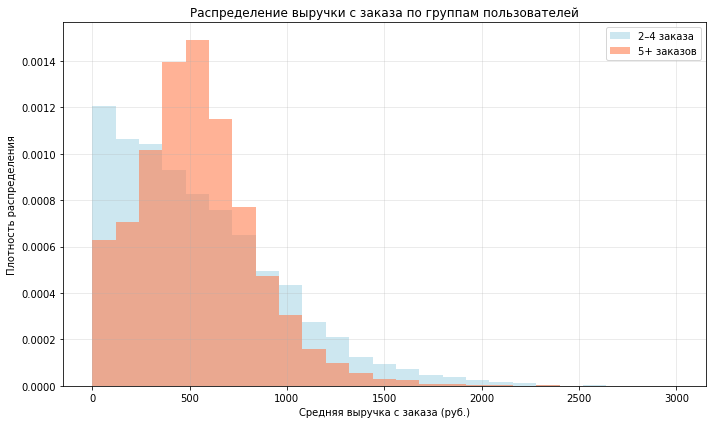

In [178]:
# Гистограммы распределения
plt.figure(figsize=(10, 6))
bins = 25
range_lim = (0, 3000)

plt.hist(
    group_2to4['avg_revenue_per_order'],
    bins=bins,
    range=range_lim,
    alpha=0.6,
    label='2–4 заказа',
    color='lightblue',
    density=True
)

plt.hist(
    group_5plus['avg_revenue_per_order'],
    bins=bins,
    range=range_lim,
    alpha=0.6,
    label='5+ заказов',
    color='coral',
    density=True
)

plt.xlabel('Средняя выручка с заказа (руб.)')
plt.ylabel('Плотность распределения')
plt.title('Распределение выручки с заказа по группам пользователей')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

Сдвиг вправо у «5+»: пользователи этой группы регулярно делают более дорогие заказы.

а) 25‑й перцентиль (нижняя четверть)
<br/>2–4 заказа: 218,42 руб., следовательно у 25 % пользователей этой группы выручка с заказа ≤ 218,42 руб.
<br/>5+ заказов: 330,46 руб., следовательно у 25 % пользователей этой группы выручка ≤ 330,46 руб.
<br/>Вывод:в группе «5+» даже минимальные чеки заметно выше (+51 % к группе «2–4»). Это значит, что среди часто заказывающих почти нет пользователей с очень дешёвыми билетами, а порог входа в группу «5+» предполагает более высокие траты уже на ранних этапах.
<br/>
<br/>б) 50‑й перцентиль (медиана)
<br/>2–4 заказа: 471,27 руб., следовательно половина пользователей этой группы тратит ≤ 471,27 руб. за заказ.
<br/>5+ заказов: 512,65 руб., следовательно половина пользователей этой группы тратит ≤ 512,65 руб. за заказ.
<br/>Вывод: медиана у «5+» на 8,8 % выше. «Типичный» пользователь, делающий 5+ заказов, тратит больше за заказ.
<br/>
<br/>в) 75‑й перцентиль (верхняя четверть)
<br/>2–4 заказа: 798,54 руб., следовательно 75 % пользователей этой группы тратят ≤ 798,54 руб. за заказ.
<br/>5+ заказов: 700,81 руб., следовательно 75 % пользователей этой группы тратят ≤ 700,81 руб. за заказ.
<br/>Вывод: в группе «2–4 заказа» больше пользователей с очень дорогими билетами (например, единичные VIP‑покупки), а в группе «5+» распределение «сжато» — даже в верхней четверти чеки ниже.
<br/>
<br/>Форма распределения:
<br/>у «5+» более «плотное» распределение (медиана и 75‑й перцентиль ближе друг к другу);
<br/>у «2–4» более «растянутое» (большой разрыв между медианой и 75‑м перцентилем).
<br/>
<br/>Итоговый вывод:
<br/>пользователи с 5+ заказами тратят больше за заказ в нижней и средней части распределения (25‑й и 50‑й перцентили), а в верхней части (75‑й перцентиль) разница обратная: в группе «2–4» встречаются более дорогие заказы. Это говорит о том, что пользователи 5+ заказов регулярно делают более дорогие заказы, а пользователи с 2–4 заказами могут совершать единичные дорогие покупки, но это не гарантирует их долгосрочную вовлечённость.

---

**Задача 4.2.3.** Проанализируйте влияние среднего количества билетов в заказе на вероятность повторной покупки.

- Изучите распределение пользователей по среднему количеству билетов в заказе (`avg_tickets_count`) и опишите основные наблюдения.
- Разделите пользователей на несколько сегментов по среднему количеству билетов в заказе:
    - от 1 до 2 билетов;
    - от 2 до 3 билетов;
    - от 3 до 5 билетов;
    - от 5 и более билетов.
- Для каждого сегмента подсчитайте общее число пользователей и долю пользователей, совершивших повторные заказы.
- Ответьте на вопросы:
    - Как распределены пользователи по сегментам — равномерно или сконцентрировано?
    - Есть ли сегменты с аномально высокой или низкой долей повторных покупок?

---

In [179]:
# Определяем сегменты по avg_tickets_count
bins = [1, 2, 3, 5, float('inf')]
labels = ['1–2 билета', '2–3 билета', '3–5 билетов', '5+ билетов']
user_profile_filtered['ticket_segment'] = pd.cut(
    user_profile_filtered['avg_tickets_per_order'],
    bins=bins,
    labels=labels,
    right=False  # интервал [left, right)
)

In [180]:
# Группируем по сегменту, считаем:
# - число пользователей;
# - число пользователей с повторными заказами (total_orders >= 2);
# - долю повторных заказов.
segmentation = (
    user_profile_filtered
    .groupby('ticket_segment')
    .agg(
        total_users=('user_id', 'count'),
        repeat_users=('total_orders', lambda x: (x >= 2).sum())
    )
    .assign(
        repeat_rate=lambda x: x['repeat_users'] / x['total_users']
    )
    .round(4)
)

In [181]:
# Выводим результат
print("Сегментация пользователей по среднему количеству билетов в заказе")
print("=" * 60)
print(segmentation.to_string())

Сегментация пользователей по среднему количеству билетов в заказе
                total_users  repeat_users  repeat_rate
ticket_segment                                        
1–2 билета             2419          1241       0.5130
2–3 билета             9498          6989       0.7358
3–5 билетов            9060          4916       0.5426
5+ билетов              661           124       0.1876


<b/>Распределение пользователей по сегментам — не равномерное, а сконцентрированное.</b>
<br/>Большая часть пользователей сосредоточена в сегментах:
<br/>«2–3 билета» — 9 498 пользователей (≈ 41,3 % от общего числа);
<br/>«3–5 билетов» — 9 060 пользователей (≈ 39,4 %).
<br/>Меньшие доли приходятся на:
<br/>«1–2 билета» — 2 419 пользователей (≈ 10,5 %);
<br/>«5+ билетов» — 661 пользователь (≈ 2,9 %).
<br/>Таким образом, свыше 80 % пользователей попадают в сегменты «2–3 билета» и «3–5 билетов».
<br/><b/>Есть сегменты с аномально высокой и низкой долей повторных покупок:</b>
<br/>- аномально высокая доля повторных покупок — в сегменте «2–3 билета» (73,58 %). 
<br/>- аномально низкая доля повторных покупок — в сегменте «5+ билетов» (18,76 %).

---

# 4.3. Исследование временных характеристик первого заказа и их влияния на повторные покупки

Изучите временные параметры, связанные с первым заказом пользователей:

- день недели первой покупки;
- время с момента первой покупки — лайфтайм;
- средний интервал между покупками пользователей с повторными заказами.

---

**Задача 4.3.1.** Проанализируйте, как день недели, в которой была совершена первая покупка, влияет на поведение пользователей.

- По данным даты первого заказа выделите день недели.
- Для каждого дня недели подсчитайте общее число пользователей и долю пользователей, совершивших повторные заказы. Результаты визуализируйте.
- Ответьте на вопрос: влияет ли день недели, в которую совершена первая покупка, на вероятность возврата клиента?

---


In [182]:
# Находим первую покупку для каждого пользователя
first_orders = user_profile_filtered[['user_id', 'total_orders','first_order_date']]
first_orders_repeat = first_orders[first_orders['total_orders'] > 1]

In [183]:
# Добавляем день недели первой покупки
first_orders['first_day'] = first_orders['first_order_date'].dt.day_name()

In [184]:
# Определяем, кто совершил повторные заказы
# repeat_status = first_orders.copy()
first_orders['is_repeat'] = first_orders['total_orders'] >= 2
first_orders

,user_id,total_orders,first_order_date,first_day,is_repeat
0,0002849b70a3ce2,1,2024-08-20 16:08:03,Tuesday,False
1,0005ca5e93f2cf4,2,2024-07-23 18:36:24,Tuesday,True
2,000898990054619,3,2024-07-13 19:40:48,Saturday,True
3,00096d1f542ab2b,1,2024-08-15 16:48:48,Thursday,False
4,000a55a418c128c,2,2024-09-29 19:39:12,Sunday,True
...,...,...,...,...,...
21849,fff13b79bd47d7c,9,2024-07-16 22:17:10,Tuesday,True
21850,fff32fc9ad0f9f6,2,2024-08-15 14:36:28,Thursday,True
21851,fffcd3dde79eb2c,33,2024-06-20 19:57:25,Thursday,True
21852,fffeeb3c120cf0b,1,2024-09-24 10:07:42,Tuesday,False


In [185]:
# Группируем по дню недели, считаем:
# total_users - число пользователей;
# is_repeat - число с повторными заказами;
# repeat_rate - долю повторных заказов.
analysis = (first_orders.groupby('first_day').agg(total_users=('user_id', 'count'), repeat_users=('is_repeat', 'sum')).
            assign(repeat_rate=lambda x: x['repeat_users'] / x['total_users']).round(4))
# все беру в скобки, чтобы перенести код на следующую строку и не возникала синтаксическая ошибка

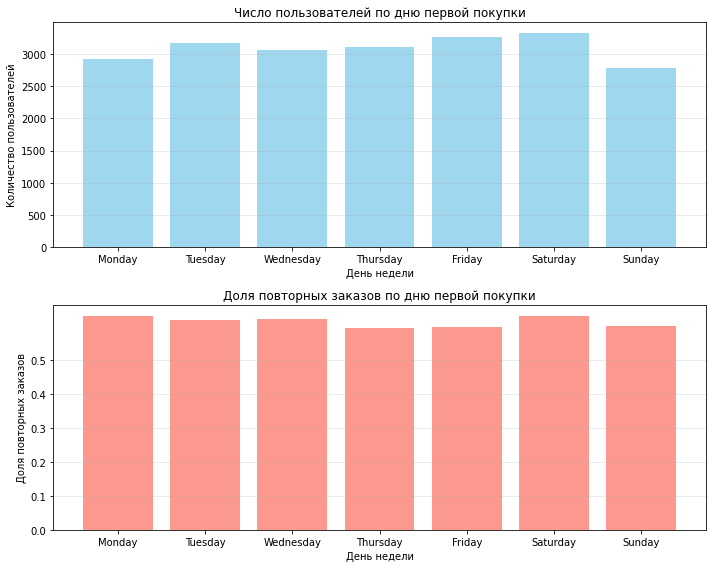

Анализ влияния дня недели первой покупки на повторные заказы
           total_users  repeat_users  repeat_rate
first_day                                        
Monday            2930          1847       0.6304
Tuesday           3176          1966       0.6190
Wednesday         3057          1901       0.6219
Thursday          3113          1850       0.5943
Friday            3259          1950       0.5983
Saturday          3326          2089       0.6281
Sunday            2777          1667       0.6003


In [186]:
# Восстанавливаем порядок дней недели (понедельник — воскресенье)
days_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday','Friday', 'Saturday', 'Sunday']
analysis = analysis.reindex(days_order)
# Метод .reindex() переупорядочивает строки DataFrame analysis так, чтобы их индексы (в данном случае 
# — значения столбца first_day) шли в точном соответствии со списком days_order

# Визуализация
fig, ax = plt.subplots(2, 1, figsize=(10, 8))

# График 1: число пользователей по дням недели
ax[0].bar(analysis.index, analysis['total_users'], color='skyblue', alpha=0.8)
ax[0].set_title('Число пользователей по дню первой покупки')
ax[0].set_xlabel('День недели')
ax[0].set_ylabel('Количество пользователей')
ax[0].grid(axis='y', alpha=0.3)

# График 2: доля повторных заказов по дням недели
ax[1].bar(
    analysis.index,
    analysis['repeat_rate'],
    color='salmon',
    alpha=0.8
)
ax[1].set_title('Доля повторных заказов по дню первой покупки')
ax[1].set_xlabel('День недели')
ax[1].set_ylabel('Доля повторных заказов')
ax[1].set_yticks([0, 0.1, 0.2, 0.3, 0.4, 0.5])
ax[1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

# Вывод таблицы результатов
print("Анализ влияния дня недели первой покупки на повторные заказы")
print(analysis)

Наибольшая доля повторных заказов — в понедельник (63%).
<br/>Минимальная доля — в четверг (59,4%) и пятницу (59,8%).
<br/>Разница между крайними значениями — 3,6%.
<br/>Самые массовые дни первой покупки: суббота (3326 пользователей), пятница (3259), вторник (3176).
<br/>Наименьшая активность — в воскресенье (2777 пользователей).
<br/>День недели первой покупки влияет на вероятность повторного заказа, но разница умеренная (3,6%).
<br/>Понедельник и суббота — лучшие дни для формирования лояльности.
<br/>Четверг и пятница требуют дополнительной работы с удержанием клиентов.
<br/>Данные подтверждают, что стратегия удержания должна учитывать день недели первой покупки.

---

**Задача 4.3.2.** Изучите, как средний интервал между заказами влияет на удержание клиентов.

- Рассчитайте среднее время между заказами для двух групп пользователей:
    - совершившие 2–4 заказа;
    - совершившие 5 и более заказов.
- Исследуйте, как средний интервал между заказами влияет на вероятность повторного заказа, и сделайте выводы.

---


In [187]:
# Формируем датасет по пользователям, совершивших более 2 заказов и их среднему интервалу между заказами
orders_mean_time = user_profile_filtered[['user_id', 'total_orders','avg_time_between_orders']]
orders_mean_time = orders_mean_time[orders_mean_time['total_orders'] > 1]
orders_mean_time

,user_id,total_orders,avg_time_between_orders
1,0005ca5e93f2cf4,2,74 days 19:19:38
2,000898990054619,3,50 days 21:45:36
4,000a55a418c128c,2,15 days 14:49:52
5,000cf0659a9f40f,13,0 days 01:30:04.250000
6,00147c9209d45d3,2,0 days 00:01:54
...,...,...,...
21847,ffecf05f1f6a9c6,4,19 days 20:53:24
21848,ffed3ff067d4f12,4,26 days 00:16:17.666666666
21849,fff13b79bd47d7c,9,13 days 08:31:50.250000
21850,fff32fc9ad0f9f6,2,74 days 09:04:10


In [188]:
# Выделяем две группы
# Группа 1: 2–4 заказа
group_2to4 = orders_mean_time[orders_mean_time['total_orders'].between(2, 4)]
# Группа 2: 5+ заказов
group_5plus = orders_mean_time[orders_mean_time['total_orders'] >= 5]

In [189]:
# Считаем средний интервал между заказами групп пользователей
mean_interval_2to4 = group_2to4['avg_time_between_orders'].mean()
mean_interval_5plus = group_5plus['avg_time_between_orders'].mean()
print("Средний интервал (2–4 заказа):", mean_interval_2to4)
print("Средний интервал (5+ заказов):", mean_interval_5plus)

Средний интервал (2–4 заказа): 21 days 09:49:25.910032181
Средний интервал (5+ заказов): 9 days 23:12:33.175451868


Пользователи, сделавшие 5 и более заказов, возвращаются в среднем на 11 дней быстрее, чем те, кто сделал 2–4 заказа. Это говорит о более высокой лояльности и привычке к сервису у «частых» покупателей.
На основе полученных данных можно стимулировать клиентов из группы «2–4» перейти в группу «5+».

---

# 4.4. Корреляционный анализ количества покупок и признаков пользователя

Изучите, какие характеристики первого заказа и профиля пользователя могут быть связаны с числом покупок. Для этого используйте универсальный коэффициент корреляции `phi_k`, который позволяет анализировать как числовые, так и категориальные признаки.

---

**Задача 4.4.1:** Проведите корреляционный анализ:
- Рассчитайте коэффициент корреляции `phi_k` между признаками профиля пользователя и числом заказов (`total_orders`). При необходимости используйте параметр `interval_cols` для определения интервальных данных.
- Проанализируйте полученные результаты. Если полученные значения будут близки к нулю, проверьте разброс данных в `total_orders`. Такое возможно, когда в данных преобладает одно значение: в таком случае корреляционный анализ может показать отсутствие связей. Чтобы этого избежать, выделите сегменты пользователей по полю `total_orders`, а затем повторите корреляционный анализ. Выделите такие сегменты:
    - 1 заказ;
    - от 2 до 4 заказов;
    - от 5 и выше.
- Визуализируйте результат корреляции с помощью тепловой карты.
- Ответьте на вопрос: какие признаки наиболее связаны с количеством заказов?

---

In [190]:
# Определяем интервальные (числовые) столбцы
interval_cols = ['total_orders','total_revenue','total_tickets','avg_revenue_per_order','avg_tickets_per_order']

In [191]:
columns_to_analyze = [
    'total_orders','total_revenue', 'total_tickets', 'first_device',
    'first_region', 'first_partner', 'first_event_type',
    'avg_revenue_per_order', 'avg_tickets_per_order'
]

In [192]:
data_subset = user_profile_filtered[columns_to_analyze]

In [193]:
# проверка размера данных
print(data_subset.shape)
print(data_subset.memory_usage(deep=True).sum() / 1024**2, "МБ")  # объём в МБ

(21638, 9)
10.921286582946777 МБ


In [194]:
# проверка типов данных
print(data_subset.dtypes)
print("Числовые столбцы:", data_subset[interval_cols].dtypes)

total_orders               int64
total_revenue            float32
total_tickets              int64
first_device              object
first_region              object
first_partner             object
first_event_type          object
avg_revenue_per_order    float64
avg_tickets_per_order    float64
dtype: object
Числовые столбцы: total_orders               int64
total_revenue            float32
total_tickets              int64
avg_revenue_per_order    float64
avg_tickets_per_order    float64
dtype: object


In [195]:
# проверка наличия пропущенных значений
print(data_subset.isna().sum())

total_orders             0
total_revenue            0
total_tickets            0
first_device             0
first_region             0
first_partner            0
first_event_type         0
avg_revenue_per_order    0
avg_tickets_per_order    0
dtype: int64


In [196]:
# small_sample = data_subset.head(1000)  # первые 1000 строк
correlation_matrix = phik_matrix(data_subset, interval_cols=interval_cols)

In [197]:
# Выводим результат
print(correlation_matrix[['total_orders']])  # корреляция всех признаков с total_orders

                       total_orders
total_orders               1.000000
total_revenue              0.764775
total_tickets              0.966498
first_device               0.025945
first_region               0.113663
first_partner              0.027483
first_event_type           0.027745
avg_revenue_per_order      0.220091
avg_tickets_per_order      0.225904


In [198]:
# pip install --upgrade phik pandas numpy # обновление библиотеки phik

Сильные корреляции: total_tickets (0.966), total_revenue (0.765), слабые корреляции: все категориальные признаки (first_device, first_region и др.) — 0.025–0.114, умеренные корреляции: avg_revenue_per_order (0.220), avg_tickets_per_order (0.226).
<br/>Интерпретация ключевых связей:
<br/>total_tickets (0.966) почти линейная зависимость: чем больше заказов, тем больше суммарных билетов.
<br/>total_revenue (0.765) рост числа заказов ведёт к росту выручки.
<br/>Категориальные признаки практически не влияют на число заказов.

In [199]:
# Определение сегментов через бинарные флаги
def assign_segment_from_flags(row):
    if row['is_two'] == 0:
        return '1_order'
    elif row['is_five'] == 0:
        return '2-4_orders'
    else:
        return '5+_orders'

user_profile_filtered['order_segment'] = user_profile_filtered.apply(assign_segment_from_flags, axis=1)

# Проверим размеры сегментов
print("\nРазмер сегментов:")
print(user_profile_filtered['order_segment'].value_counts())


Размер сегментов:
1_order       8368
2-4_orders    7147
5+_orders     6123
Name: order_segment, dtype: int64


In [200]:
# Числовые (интервальные) столбцы для phik
interval_cols_small = [
    'total_orders',
    'total_revenue',
    'total_tickets',
    'avg_revenue_per_order',
    'avg_tickets_per_order'
]

# Все столбцы, включая категориальные и целевые
columns_to_analyze_small = [
    'total_orders', 'total_revenue', 'total_tickets', 'first_device',
    'first_region', 'first_partner', 'first_event_type',
    'avg_revenue_per_order', 'avg_tickets_per_order',
    'is_two', 'is_five'
]

Примечание: В сегменте '1_order' столбец 'total_orders' отсутствует в матрице корреляций, так как все пользователи имеют 1 заказ (нулевая вариация).

--- Сегмент: 1_order (8368 пользователей) ---

--- Сегмент: 2-4_orders (7147 пользователей) ---
                       total_orders
total_orders               1.000000
total_tickets              0.664238
total_revenue              0.394786
avg_tickets_per_order      0.369364
avg_revenue_per_order      0.107162
first_partner              0.064842
first_device               0.009622
first_region               0.000000
first_event_type           0.000000


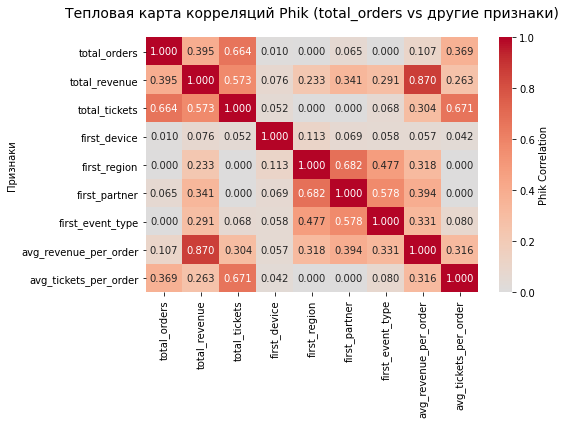


--- Сегмент: 5+_orders (6123 пользователей) ---
                       total_orders
total_orders               1.000000
total_tickets              0.968057
total_revenue              0.757285
avg_revenue_per_order      0.238158
avg_tickets_per_order      0.160123
first_region               0.159575
first_event_type           0.044839
first_partner              0.037664
first_device               0.000000


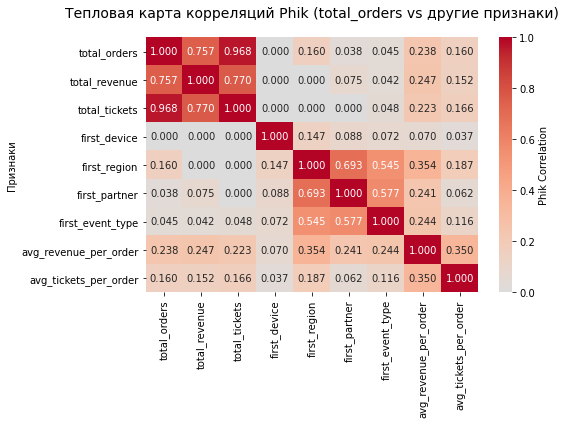

In [201]:
segments = {}
for seg in ['1_order', '2-4_orders', '5+_orders']:
    segments[seg] = user_profile_filtered[user_profile_filtered['order_segment'] == seg]

print("Примечание: В сегменте '1_order' столбец 'total_orders' отсутствует в матрице корреляций, так как все пользователи имеют 1 заказ (нулевая вариация).")
    
# Для каждого сегмента — своя матрица корреляций
for seg_name, seg_data in segments.items():
    # Подмножество данных
    subset = seg_data[columns_to_analyze_small].copy()
    # Расчёт матрицы Phik
    corr_matrix = phik_matrix(subset, interval_cols=interval_cols_small)
    print(f"\n--- Сегмент: {seg_name} ({len(subset)} пользователей) ---")
    if seg_name in ['2-4_orders', '5+_orders']:
        print(corr_matrix[['total_orders']].sort_values(by='total_orders', ascending=False))
        correlation_df = pd.DataFrame(corr_matrix)
        plt.figure(figsize=(8, 6))
        sns.heatmap(
            correlation_df,                # данные
            annot=True,                     # показать значения в ячейках
            cmap='coolwarm',               # цветовая схема: синий → красный
            center=0,                      # центр цветовой шкалы (0)
            square=False,                  # ячейки не обязательно квадратные
            fmt='.3f',                   # формат чисел: 3 знака после запятой
            cbar_kws={'label': 'Phik Correlation'}  # подпись шкалы
        )
        plt.title('Тепловая карта корреляций Phik (total_orders vs другие признаки)', fontsize=14, pad=20)
        plt.ylabel('Признаки')  # подпись оси Y
        plt.xlabel('')        # убираем подпись оси X (она не нужна)
        plt.tight_layout()
        plt.show()

<b/>Выводы</b>
<br/>1. Сегмент «1_order» (8 368 пользователей):
<br/>Полностью отсутствует вариация по total_orders (все пользователи имеют ровно 1 заказ), как следствие невозможно рассчитать корреляции с total_orders, так как константа не коррелирует ни с чем.
<br/>2. Сегмент «2–4_orders» (7 147 пользователей):
<br/>Сильные связи total_orders c total_tickets (0.664).Чем больше заказов, тем больше билетов. total_orders с total_revenue (0.395). Рост заказов ведёт к росту выручки.
<br/>3. Сегмент «5+_orders» (6 123 пользователя):
total_orders c total_tickets (0.968) Почти линейная зависимость: много заказов = много билетов. total_orders с total_revenue (0.757). Явный рост выручки с увеличением числа заказов.
<br/>4. Общие выводы:
<br/>Чем выше активность пользователя (больше заказов), тем сильнее связь между заказами, выручкой и билетами.
<br/>Каналы привлечения и регион играют второстепенную роль во всех сегментах.

# 5. Общий вывод и рекомендации

В конце проекта напишите общий вывод и рекомендации: расскажите заказчику, на что нужно обратить внимание. В выводах кратко укажите:

- **Информацию о данных**, с которыми вы работали, и то, как они были подготовлены: например, расскажите о фильтрации данных, переводе тенге в рубли, фильтрации выбросов.
- **Основные результаты анализа.** Например, укажите:
    - Сколько пользователей в выборке? Как распределены пользователи по числу заказов? Какие ещё статистические показатели вы подсчитали важным во время изучения данных?
    - Какие признаки первого заказа связаны с возвратом пользователей?
    - Как связаны средняя выручка и количество билетов в заказе с вероятностью повторных покупок?
    - Какие временные характеристики влияют на удержание (день недели, интервалы между покупками)?
    - Какие характеристики первого заказа и профиля пользователя могут быть связаны с числом покупок согласно результатам корреляционного анализа?
- Дополните выводы информацией, которая покажется вам важной и интересной. Следите за общим объёмом выводов — они должны быть компактными и ёмкими.

В конце предложите заказчику рекомендации о том, как именно действовать в его ситуации. Например, укажите, на какие сегменты пользователей стоит обратить внимание в первую очередь, а какие нуждаются в дополнительных маркетинговых усилиях.

<b/>Информация о данных</b>
<br/>Анализируемый датасет включает 290 611 строк и 15 столбцов, названия которых приведены к единому стилю snake_case — это делает их понятными и удобными для работы.По типам данных столбцы распределяются следующим образом: 8 столбцов имеют тип object (категориальные данные), 5 — числовые, и ещё 2 представлены в формате datetime64.
<br/>Ключевые особенности набора данных:
<br/>единственный столбец с пропусками — days_since_prev, при этом доля пропусков незначительна;
<br/>сохранять тип float64 для days_since_prev важно, поскольку он позволяет корректно отображать пропуски;
<br/>для ряда числовых столбцов возможно снижение размерности без ущерба для качества данных.
<br/>В целом, данные полностью соответствуют заявленному описанию и не вызывают вопросов к корректности.
<br/>Для приведения выручки к единой валюте (российскому рублю) был использован датасет с курсами казахстанского тенге к российскому рублю за 2024 год (df_exchange). После загрузки этого датасета тип данных поля data изменили с object на datetime64 — это позволило корректно сопоставить его со значениями поля order_dt в основном датасете (df). Затем суммы в тенге перевели в рубли и сохранили результаты в новом столбце revenue_rub датасета df (тип данных — float64).
<br/>Следующий этап — проверка датасета df на пропуски. Они обнаружились только в столбце days_since_prev и составили 7,6 % от общего количества записей. Удалять строки с пропусками не стали, чтобы не исказить результаты последующего исследовательского анализа данных.
<br/>Далее была оптимизирована структура датасета:
<br/>изменили тип данных столбца order_dt;
<br/>понизили размерность числовых столбцов (revenue, revenue_rub, days_since_prev, order_id, tickets_count, event_id).
<br/>После этого проверили категории в столбцах с номинальными данными — явных ошибок не выявили. При этом в столбце event_type_main значение «другое» может указывать на отсутствие информации.
<br/>Завершающий этап — анализ распределения числовых данных и поиск выбросов в столбцах tickets_count и revenue_rub:
<br/>в tickets_count зафиксирована высокая вариативность и отрицательная асимметрия (скос влево). Медиана (3 билета) отражает «типичное» значение. Всего выявлено 126 выбросов — заказы с 8 и более билетами.
<br/>в revenue_rub сначала обнаружили 381 запись с отрицательной выручкой — значения исправили на положительные. Затем выявили экстремальные выбросы и отфильтровали данные по 99‑му процентилю. Доля отфильтрованных записей составила 0,00972. Анализ показал высокую вариативность и положительную асимметрию (скос вправо). Всего зафиксировано 8 368 выбросов (выручка ≥ 1 804,28 руб.), что соответствует 2,9 % данных после фильтрации.

<b/>Основные результаты анализа</b>
<br/>Общее число пользователей в отфильтрованном датасете: 21638, средний доход с одного заказа — 522,2 руб.
<br/>Объём покупок за заказ: в среднем в заказе 2,74 билета; разброс небольшой (от 1 до 11), большинство значений сконцентрировано вокруг медианы (~2,75–3,1 билета).
<br/>Периодичность заказов: в среднем между заказами проходит 15,7 дней, но разброс велик (стандартное отклонение — 22,3 дня); половина пользователей делает повторные заказы в течение 8 дней, 75 % — в течение 20 дней; максимум — 148 дней между заказами: есть как частые, так и редкие покупатели.
<br/>По числу заказов пользователи распределены следующим образом:
<br/>1–2 билета 2419 пользователей;
<br/>2–3 билета 9498 пользователей;
<br/>3–5 билетов 9060 пользователей;
<br/>5+ билетов 661 пользователей.
<br/>По результатам группировки пользователей по признакам первого заказа можно сделать следующий вывод? что во всех категориях распределение пользователей не является равномерным — есть выраженные «точки входа» с наибольшим числом пользователей:
<br/>- тип мероприятия: концерты;
<br/>- устройство: mobile;
<br/>- регион: Каменевский регион;
<br/>- партнёр: «Билеты без проблем».
<br/> Самые сильные признаки возврата фиксируются: 
<br/>- по регионам («Шанырский регион» — 67 %) и партнёрам («Край билетов», «Дом культуры» — по 65 %);
<br/>- по типу мероприятия выделяется сегмент «выставки» (64 %) — возможно, аудитория этого формата более вовлечена;
<br/>- пользователи с desktop возвращаются чаще (64 % против 61 % у mobile), что может указывать на более осознанный выбор при заказе с ПК.
<br/>В остальных сегментах доля повторных заказов близка к среднему уровню или ниже него.
<br/> Более высокая средняя выручка связана с повторными заказами, но не за счёт очень дорогих покупок, а за счёт устойчиво более высоких трат.
<br/>Наиболее массовый сегмент («2–3 билета») одновременно демонстрирует наибольшую лояльность (73,6 % возвращаются).
<br/>Наименее лояльны пользователи из сегмента «5+ билетов»: несмотря на высокий первоначальный объём покупок, лишь 18,8 % делают повторные заказы. Это может указывать на разовый характер спроса или недостаточную вовлечённость данной группы.
<br/>Пользователи, сделавшие 5 и более заказов, возвращаются в среднем на 11 дней быстрее, чем те, кто сделал 2–4 заказа. Это говорит о более высокой лояльности и привычке к сервису у "частых" покупателей. На основе полученных данных можно стимулировать "частых" клиентов из группы «2–4» перейти в группу «5+».
<br/> Корреляционный анализ показывает, что чем выше активность пользователя (больше заказов), тем сильнее связь между заказами, выручкой и билетами. Каналы привлечения и регион играют второстепенную роль во всех сегментах.

<br/><b/>Рекомендации заказчику:</b>
<br/>- использовать данные о типе мероприятий, регионе и устройстве для точечных предложений;
<br/>- регулярно мониторить эффективность регионов, партнёров и типов мероприятий; тиражировать лучшие практики;
<br/>- применять следующие метрики для контроля: доля повторных заказов по сегментам; средний интервал между заказами; конверсия из первого заказа в повторный;
<br/>- сосредоточиться на удержании и развитии лояльных сегментов («2–3 билета», активные пользователи), одновременно повышая вовлечённость в группах с низкой повторной активностью («5+ билетов», «1–2 билета»). Оптимизация каналов привлечения и персонализация предложений помогут увеличить общую частоту заказов и выручку.

# 6. Финализация проекта и публикация в Git

Когда вы закончите анализировать данные, оформите проект, а затем опубликуйте его.

Выполните следующие действия:

1. Создайте файл `.gitignore`. Добавьте в него все временные и чувствительные файлы, которые не должны попасть в репозиторий.
2. Сформируйте файл `requirements.txt`. Зафиксируйте все библиотеки, которые вы использовали в проекте.
3. Вынести все чувствительные данные (параметры подключения к базе) в `.env`файл.
4. Проверьте, что проект запускается и воспроизводим.
5. Загрузите проект в публичный репозиторий — например, на GitHub. Убедитесь, что все нужные файлы находятся в репозитории, исключая те, что в `.gitignore`. Ссылка на репозиторий понадобится для отправки проекта на проверку. Вставьте её в шаблон проекта в тетрадке Jupyter Notebook перед отправкой проекта на ревью.

**Вставьте ссылку на проект в этой ячейке тетрадки перед отправкой проекта на ревью.**